# Purpose:

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm

import os

import utilsProb
import utilsProbSS
import utilsProbSS_Mem1
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import properscoring as ps
from math import erf


import matplotlib
#mapping
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [6]:
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')
#reloading utils after changes:
importlib.reload(utilsProbSS_Mem1)
importlib.reload(utilsProb)
importlib.reload(utilsProbSS)


We are here: /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal


<module 'utilsProbSS' from '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProbSS.py'>

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))



In [8]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


def cdf_of_normal(true,ypred,scale):
    return 0.5*(1+erf((true-ypred)/(scale*np.sqrt(2))))

def rmse(guess,truth):
    n = len(truth)
    rms = np.linalg.norm(guess - truth) / np.sqrt(n)
    return rms


def bias(guess,truth):
    bb = np.mean(guess)-np.mean(truth)
    return bb

def corrss(guess,truth):
    bb = np.corrcoef(np.squeeze(guess),np.squeeze(truth))[0,1]
    return bb


def crmse(guess,truth):
    guess = np.squeeze(guess)
    truth = np.squeeze(truth)
    mg = np.mean(guess)
    mt = np.mean(truth)
    n = len(truth)
    bb=np.linalg.norm((guess-mg) - (truth-mt)) / np.sqrt(n)
    return bb

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def spreadskill(guess,truth,stddevver,numbins):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    distPP = np.ndarray.flatten(stddevver)
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    
    indexsort = np.argsort(distPP)
    err = (guess- truth)**2
    varianceall = distPP[indexsort]
    err_sort = err[indexsort]

    numbins = numbins 
    inds = np.zeros(len(varianceall))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(varianceall)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
    
    avgvar_m = []
    msebin_m = []

    avgvar_s = []
    msebin_s = []
    nummy =2000

    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tavg =0
        tmse =0
        tavg = np.zeros(nummy)
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tavg[ii]  = np.mean(np.random.choice(varianceall[locbin],len(locbin)))
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        avgvar_m = np.append(avgvar_m,np.mean(tavg))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        avgvar_s = np.append(avgvar_s,np.std(tavg))
        msebin_s = np.append(msebin_s,np.std(tmse))
    return avgvar_m,msebin_m,avgvar_s,msebin_s

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 8))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype,name='banjo'),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1),name='banjo2'),
  ])


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype,name='spoon'),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1),name='doon'),
  ])



def stnd_error_mean(guess,truth,numbins):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    

    err = (guess- truth)**2
    indexsort = np.argsort(err)
    err_sort = err[indexsort]
    
    truthSORT = truth[indexsort]
    guessSORT = guess[indexsort]

    numbins = numbins 
    inds = np.zeros(len(err_sort))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(err_sort)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
        
    msebin_m = []
    msebin_s = []
    nummy =2000
    maxlist=[]
    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tmse =0
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        msebin_s = np.append(msebin_s,np.std(tmse))
        
        if bb == np.max(np.unique(inds)):
            print('...getting max...')
            mlt = truthSORT[locbin]
            mlg = guessSORT[locbin]
            mle = np.sqrt((truthSORT[locbin]-guessSORT[locbin])**2)
            
        
    return msebin_m,msebin_s,mlt,mlg,mle


def crps_cost_function_LogNorm(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a lognormal distribution defined by
    the mean and standard deviation.
    Big Ups to Stephan Rasp & Sebastian Lerch. 
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    y = y_true
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y= y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    sigma = K.abs(sigma)
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    
    c1 = y * (2* 0.5 + 0.5*(tfm.erf((tfm.log(y)-mu)/(np.sqrt(2)*sigma))))
    
    c2 = 2*K.exp(mu+0.5*K.square(sigma))
    
    c3 = 0.5 + 0.5*(tfm.erf((tfm.log(y)-(mu+sigma**2))/(np.sqrt(2)*sigma)))
    
    c4 = (0.5*(1+tfm.erf((sigma/np.sqrt(2))/np.sqrt(2))))-1
    
    # First we will compute the crps for each input/target pair
    crps = c1-c2*(c3+c4)
        
    # Then we take the mean. The cost is now a scalar
    diff = y-(K.exp(mu+((K.square(sigma))/2)))
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx())*1 #0 for lower, 1 for greater
#     greater = greater + 1                 #1 for lower, 5 for greater

    return K.mean(crps) #+ K.mean(greater*diff)

def crps_logis_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a logistic distribution defined by
    the mean and standard deviation.
    Big Ups to Stephan Rasp & Sebastian Lerch. 
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    y = y_true
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y= y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    sigma = K.abs(sigma)
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    
    
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc-2*K.log(1/(1+K.exp(-loc)))-1)
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)


def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tfm.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)


#MAKE SURE YOUR true values are NEVER zero when using this. 


def crps_Lnorm_TEST(y_true, y_pred, sig_pred):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    # Split input
    mu = y_pred
    sigma = sig_pred
    y = y_true
    c1 = y * (2*plnorm(y,mu,sigma)-1)
    c2 = 2*np.exp(mu+0.5*sigma**2)
    c3 = plnorm(y,mu+sigma**2,sigma) 
    c4 = pnorm(sigma/np.sqrt(2))-1
    crps = c1-c2*(c3+c4)
    return np.mean(crps)


def crps_logis_TEST(y_true, y_pred, sig_pred):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred
    sigma = sig_pred
    var = sigma**2
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / np.sqrt(var)
    # First we will compute the crps for each input/target pair
    crps =  np.sqrt(var) * (loc-2*np.log(1/(1+np.exp(-loc)))-1)
    # Then we take the mean. The cost is now a scalar
    return np.mean(crps)


def crps_TEST(y_true, y_pred, sig_pred):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred
    sigma = sig_pred

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = sigma**2
    # The following three variables are just for convenience
    loc = (y_true - mu) / np.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-(loc**2) / 2.0)
    Phi = 0.5 * (1.0 + math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  np.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return np.mean(crps)

def plnorm(y,mu,sigma):
    nummy=0.5 + 0.5*(math.erf((np.log(y)-mu)/(np.sqrt(2)*sigma)))
    return nummy 

def pnorm(loc):
    nummy=0.5*(1+math.erf(loc/np.sqrt(2)))
    return nummy 



def build_emb_model(n_features, n_outputs, hidden_nodes, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.0001,
                    loss=crps_cost_function,
                    activation='relu', reg=None):
    """
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = tf.keras.layers.Input(shape=(n_features,))
    id_in = tf.keras.layers.Input(shape=(1,))
    emb = tf.keras.layers.Embedding(max_id + 1, emb_size)(id_in)
    emb = tf.keras.layers.Flatten()(emb)
    x = tf.keras.layers.Concatenate()([features_in, emb])
    for h in hidden_nodes:
        x = tf.keras.layers.Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = tf.keras.layers.Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = tf.keras.models.Model(inputs=[features_in, id_in], outputs=x)

    if compile:
        opt = tf.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss=loss)
    return model

def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution."""
    m = np.exp(mu + sigma**2 / 2.0)
    v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return m, v


def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

In [9]:
model = build_emb_model(2,2,[20,20],2,122,compile=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 2)         246         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2)            0           embedding[0][0]                  
______________________________________________________________________________________________

## Check Region of Interest

...Searching...: /glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/
number of points: 144


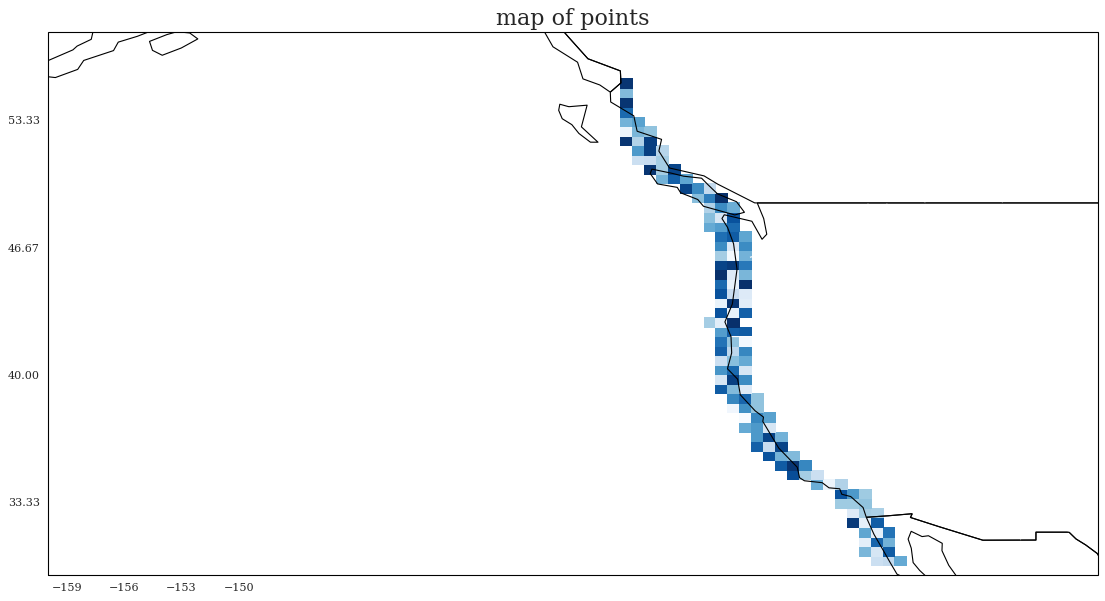

In [10]:
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
lat = np.arange(22,60.5,.5)
lon = np.arange(200.0,249.375+.625,.625)
MapPoints = np.zeros([lat.shape[0],lon.shape[0]])
print('...Searching...:',latlonfolder)
path = latlonfolder
pp_file_names = [f for f in glob.glob(path + "/lat*lon*", recursive=True)]
pp_file_names = sorted(pp_file_names)

for ff in pp_file_names:
    #find the appropriate lat/lon index
    ff2 = ff.split('lat')[1]
    ff3 = (ff2.split('lon'))
    latfind = float(ff3[0])
    lonfind = float(ff3[1])
    indlat= np.where(lat==latfind)[0][0]
    indlon= np.where(lon==lonfind)[0][0]
    MapPoints[indlat,indlon] = np.random.uniform()
    
MapPoints[MapPoints==0]=np.nan
print("number of points:", len(pp_file_names))

##################### plotting ###############################

fig = plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
cmap1 = matplotlib.cm.get_cmap("Blues",lut=55)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1,projection = proj)
ax.add_feature(cf.BORDERS)

ax.set_xticks(np.linspace(-180,-150, 11), crs=proj)
ax.set_yticks(np.linspace(20, 60, 7), crs=proj)
ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-160, -105, 29.5, 55])
scales = 1
ff = plt.pcolor(np.squeeze(lon),np.squeeze(lat),MapPoints,cmap=cmap1,vmin=0,vmax=scales)
plt.title('map of points',fontsize=20)

# savepath = dd + '/Map_of_points.pdf'
# plt.savefig(savepath , dpi=80)
plt.show()
# plt.close('all')

## What time step to look at: 

In [11]:
stepnum=3

dd = '/glade/scratch/wchapman/GEFS/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())

/glade/scratch/wchapman/GEFS/F012
/glade/scratch/wchapman/GEFS/F024
/glade/scratch/wchapman/GEFS/F048


In [12]:
path

'/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'

In [14]:
batch_num = 50
epochs = 30
#find all files in directory                                                                                                                                                  
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/*mem1*.nc", recursive=True)])
for f in train_file_names:
    print(f)
All_file_names =train_file_names

Training on
/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc
/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc
/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc


In [16]:
rang = 144
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind_gefs(latlonfolder)
latsDO.shape
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])

norm_dict = utilsProbSS_Mem1.get_image_normalization_params(All_file_names,latind,lonind)
sys.stdout.flush()
norm_dict_targ = utilsProbSS_Mem1.get_image_normalization_params_targ(All_file_names,latind,lonind)

# sys.stdout.flush()
num_samps_train = utilsProbSS_Mem1.count_samps(All_file_names,latind,lonind)
# num_samps_val = utilsProb.count_samps(validate_file_names)
# num_samps_test = utilsProb.count_samps(test_file_names)

print('number of training samples:',num_samps_train)
# sys.stdout.flush()
num_samps_tot = num_samps_train

Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...


Mean and standard deviation for "IVT" = 148.2705, 133.3613
Mean and standard deviation for "lat" = 41.7743, 6.9695
Mean and standard deviation for "lon" = 236.3845, 3.6445
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...


Mean and standard deviation for "IVTm" = 146.0647, 135.7915
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
number o

In [17]:
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')
#reloading utils after changes:
importlib.reload(utilsProbSS_Mem1)
importlib.reload(utilsProb)


We are here: /glade/scratch/wchapman/GEFS/F048


<module 'utilsProb' from '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py'>

## Only for this one
We do not normalize the target dictionary

In [18]:
norm_dict_targ['IVTm'][0]=0
norm_dict_targ['IVTm'][1]=1

In [37]:
x

array([[-0.8334157 , -1.689416  ],
       [-0.7682252 , -1.689416  ],
       [-0.6832292 , -1.689416  ],
       ...,
       [-0.24136896,  1.7541828 ],
       [-0.2319571 ,  1.8259245 ],
       [-0.11683264,  1.8976661 ]], dtype=float32)

# Big Loop
Run this off this notebook in CrossVal.py

In [38]:
All_file_names

allinds = np.arange(len(All_file_names))

for bb in range(0,len(All_file_names)):
    if bb == (len(All_file_names)-1):
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[0]]]
        val_fil_name = [All_file_names[allinds[-1]]]
        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    else:
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[bb+1]]]
        val_fil_name = [All_file_names[allinds[bb]]]
        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('testing:',test_fil_name)
    print('validatiing:',val_fil_name)
    print('#################################################')
    
    num_samps_train = utilsProbSS_Mem1.count_samps(train_fil_name,latind,lonind)
    num_samps_val = utilsProbSS_Mem1.count_samps(val_fil_name,latind,lonind)

    print('...gathering data...')
    aa = utilsProbSS_Mem1.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x = adf[0]
    y = adf[1]
    aa = utilsProbSS_Mem1.deep_learning_generator_ss_mv(val_fil_name, num_samps_val*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x_tst = adf[0]
    y_tst = adf[1]

    #remove x and y where x == 0 
    rmind = np.where(utilsProbSS_Mem1.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
    print('before shape:',y.shape)
    print('deleting:',rmind[0].shape,'indices')
    x = np.delete(x,rmind[0],0)
    y = np.delete(y,rmind[0],0)
    print('after shape:',y.shape)
    
    rmind = np.where(utilsProbSS_Mem1.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)   
    
    
    print('y_tst:',y_tst.shape[0])
    print('x_tst:',x_tst.shape[0])
    
    print('...Encoding Stations...')

    SUMID = np.unique(x[:,1]+x[:,2])
    #station ID integers 
    stID = np.zeros([x.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x[:,1]+x[:,2]==un)
        stID[mats,:] = int(jj)
    stID=stID.astype(int)

    #station ID integers 
    stID_tst = np.zeros([x_tst.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x_tst[:,1]+x_tst[:,2]==un)
        stID_tst[mats,:] = int(jj)
    stID_tst=stID_tst.astype(int)
    print('...done...')


    x=x[:,:1]
    x_tst=x_tst[:,:1]
    
    ### Model Build #### 
    
    in_shape = x.shape[1]
    print('In shape: ',in_shape)
    out_shape = 1
    print('Out shape: ',out_shape)    
    
    max_id = np.max(stID)
    
    model = build_emb_model(in_shape,2,[30,40],2,max_id,compile=True)
    
    model.summary()
    valyr= val_fil_name[0].split('_GEFS')[0]
    valyr =valyr.split('_')[1]
    
    tstyr= test_fil_name[0].split('_GEFS')[0]
    tstyr =tstyr.split('_')[1]
    print(tstyr)
    #save location:
    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Gefs_ONLYTHREE_Mem1_'+tstyr
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    
    Wsave_name = newdir+'/cpf_CRPS_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    print(Wsave_name)
    
    print(Wsave_name)
    print(Wsave_name)
    
    modsave = tf.keras.callbacks.ModelCheckpoint(Wsave_name, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min',include_optimizer=False)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001,verbose=1)
    er_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
    net_in = tf.keras.layers.Input(shape=(in_shape))
    
    #train model
    histss = model.fit([x,stID], y,validation_data=([x_tst,stID_tst],y_tst), epochs=200,batch_size=50 ,verbose=True,callbacks=[modsave,reduce_lr,er_stop]);
    
    hist_df = pd.DataFrame(histss.history) 

   
    # or save to csv: 
    hist_csv_file = newdir+'/fithist_CRPS_'+ valyr+'_test_'+tstyr+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)


#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc']
validatiing: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
before shape: (16704, 1)
deleting: (0,) indices
after shape: (16704, 1)
before shape test: (17280, 1)
deleting test: (0,) indices
after shape tst: (17280, 1)
y_tst: 17280
x_tst: 17280
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                   

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.


before shape: (34704, 1)
deleting: (0,) indices
after shape: (34704, 1)
before shape test: (16704, 1)
deleting test: (0,) indices
after shape tst: (16704, 1)
y_tst: 16704
x_tst: 16704
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 2)         288         input_21[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
____________________________________________

In [25]:
x.shape

(34704, 2)

In [26]:
y_tst = (utilsProbSS.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))

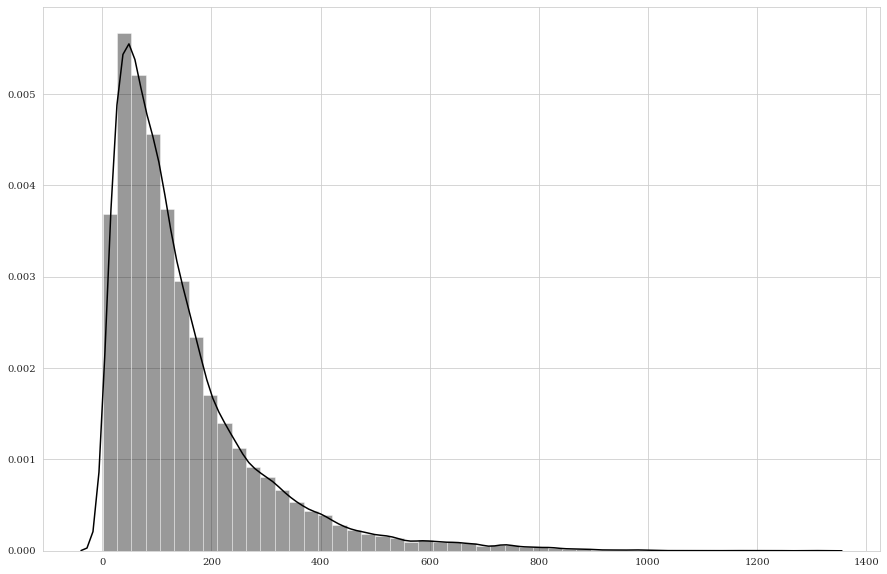

In [27]:
plt.figure(figsize=[15,10])  
sns.distplot((y),50,color='k')
plt.show()

## Big Loop 
validation data evaluation

#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
before shape: (16704, 1)
deleting: (0,) indices
after shape: (16704, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 1)]

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in double_scalars
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in exp
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: overflow encountered in exp


...binned spread skill...


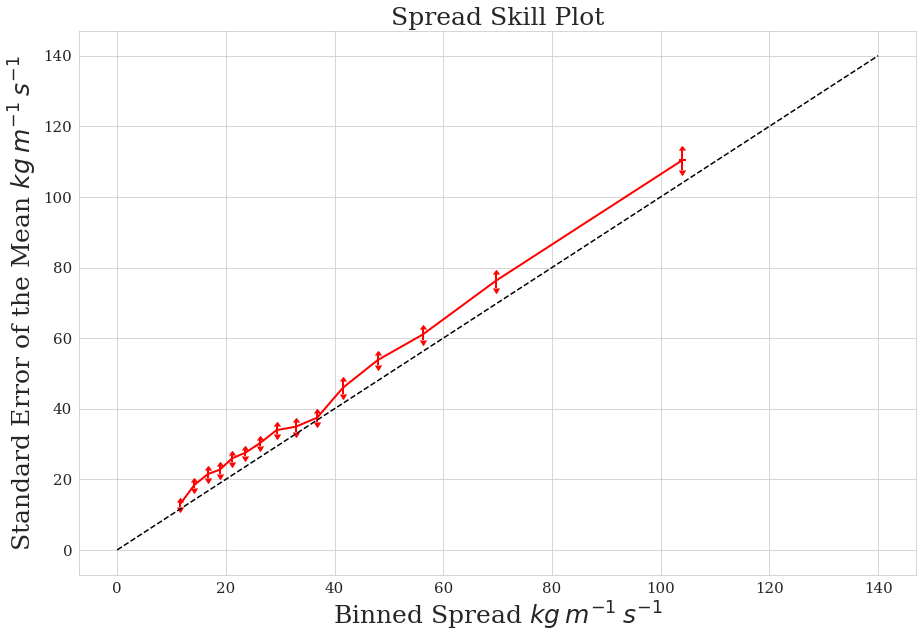

47.93208534149528
48.227893042074164
47.92668065407352
48.176001077214366
-0.7197823746436143
2.2366464821223246
#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
before shape: (17280, 1)
deleting: (0,) indices
after shape: (17280, 1)
before shape test: (16704, 1)
deleting test: (0,) indices
after shape tst: (16704, 1)
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                 

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in exp
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in double_scalars
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: overflow encountered in exp


...binned spread skill...


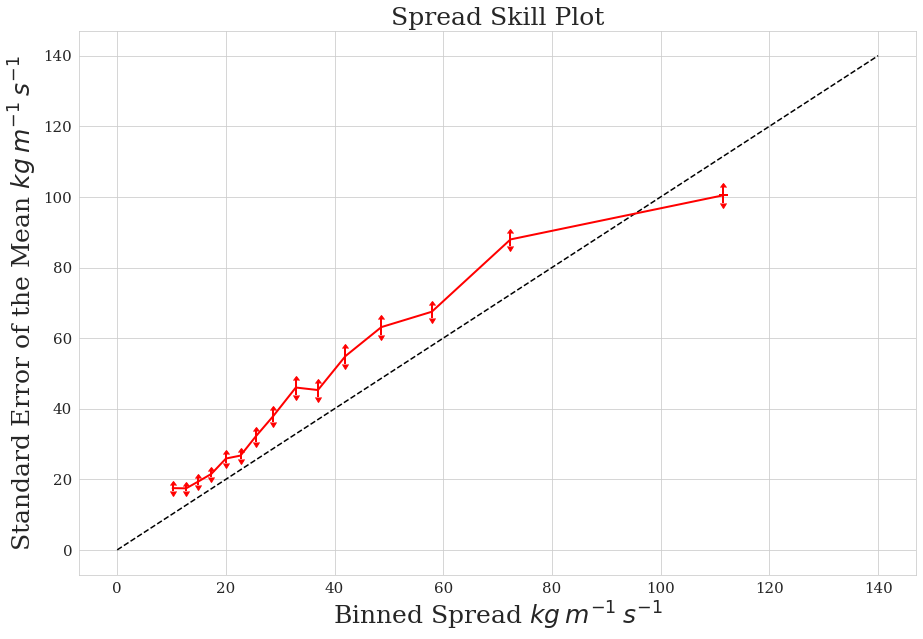

50.98045965418667
51.98058330576514
50.80311783234957
51.974729431153946
-4.2485862430417
0.7800906139240453
#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


before shape: (34704, 1)
deleting: (0,) indices
after shape: (34704, 1)
before shape test: (17280, 1)
deleting test: (0,) indices
after shape tst: (17280, 1)
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 2)         288         input_28[0][0]                   
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 1)]          0                                            
_____________________________________________________________________

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in exp
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in double_scalars
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: overflow encountered in exp


...binned spread skill...


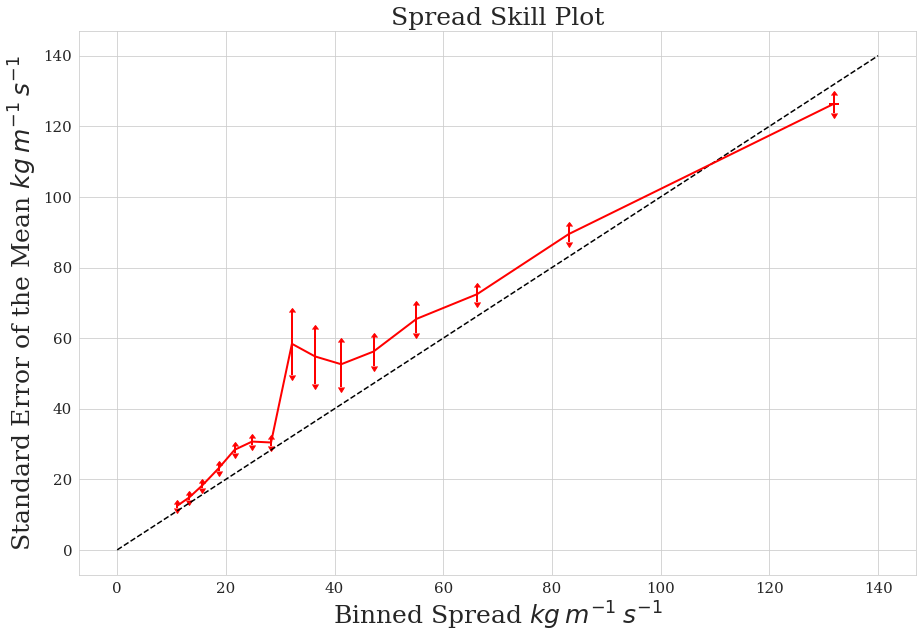

57.75917024129378
58.39030448115307
57.70245829391543
58.282115763327475
-2.558916528867911
3.552835424258177


In [39]:
All_file_names
ense = 21
numbins = 15
allinds = np.arange(len(All_file_names))


avgvar_mA = np.zeros([len(All_file_names),numbins])
msebin_mA = np.zeros([len(All_file_names),numbins])
avgvar_sA = np.zeros([len(All_file_names),numbins])
msebin_sA = np.zeros([len(All_file_names),numbins])

mAl =np.array([])
sAl =np.array([])
yAl =np.array([])

for ddfa, bb in enumerate(range(0,len(All_file_names))):

    if bb == (len(All_file_names)-1):
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[0]]]
        val_fil_name = [All_file_names[allinds[-1]]]
        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    else:
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[bb+1]]]
        val_fil_name = [All_file_names[allinds[bb]]]
        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('testing:',test_fil_name)
    print('validating:',val_fil_name)
    print('#################################################')
    
    num_samps_train = utilsProbSS_Mem1.count_samps(train_fil_name,latind,lonind)
    num_samps_val = utilsProbSS_Mem1.count_samps(val_fil_name,latind,lonind)

    print('...gathering data...')
    aa = utilsProbSS_Mem1.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x = adf[0]
    y = adf[1]
    
    ######## load testing ##############################################
    xpred = utilsProbSS_Mem1.read_image_file(test_fil_name[0],latind,lonind)
    x_tst = np.reshape(xpred['predictor_matrix'],[xpred['predictor_matrix'].shape[0]*xpred['predictor_matrix'].shape[1],xpred['predictor_matrix'].shape[2]])
    y_tst = np.reshape(xpred['target_matrix'],[xpred['target_matrix'].shape[0]*xpred['target_matrix'].shape[1]])
    x_tst = utilsProbSS.normalize_images(x_tst,xpred['predictor_names'],norm_dict)[0]
    y_tst = utilsProbSS.normalize_images_targ(y_tst,xpred['target_name'],norm_dict_targ)[0]
    y_tst = np.expand_dims(y_tst,axis=1)
    ######## load testing ##############################################
    
    #remove x and y where x ==0 
    rmind = np.where(utilsProbSS_Mem1.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
    print('before shape:',y.shape)
    print('deleting:',rmind[0].shape,'indices')
    x = np.delete(x,rmind[0],0)
    y = np.delete(y,rmind[0],0)
    print('after shape:',y.shape)
    
    
    rmind = np.where(utilsProbSS_Mem1.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)

    print('...Encoding Stations...')

    SUMID = np.unique(x[:,1]+x[:,2])
    #station ID integers 
    stID = np.zeros([x.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x[:,1]+x[:,2]==un)
        stID[mats,:] = int(jj)
    stID=stID.astype(int)

    #station ID integers 
    stID_tst = np.zeros([x_tst.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(np.around(10000*np.round((x_tst[:,1]+x_tst[:,2]),4)).astype(int)==np.around(10000*np.round(un,4)).astype(int))[0]
        stID_tst[mats,:] = int(jj)
    stID_tst=stID_tst.astype(int)
    print('...done...')

    x=x[:,:1]
    x_tst=x_tst[:,:1]
    
    ### Model Build #### 
    
    in_shape = x.shape[1]
    print('In shape: ',in_shape)
    out_shape = 1
    print('Out shape: ',out_shape)
    
    max_id = np.max(stID)
    model = build_emb_model(in_shape,2,[30,40],2,max_id,compile=True)
    model.summary()    
    valyr= val_fil_name[0].split('_GEFS')[0]
    valyr =valyr.split('_')[1]
    
    tstyr= test_fil_name[0].split('_GEFS')[0]
    tstyr =tstyr.split('_')[1]    
    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Gefs_ONLYTHREE_Mem1_'+tstyr
    Wsave_name = newdir+'/cpf_CRPS_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    print("... loading....",Wsave_name)
    
    ### CHANGE THIS FOR PRODUCTION RUNS ###########
    model.load_weights(Wsave_name)
    ### CHANGE THIS FOR PRODUCTION RUNS ###########
    
    yhat = model([x_tst,stID_tst])
    
    m = yhat[:,0].numpy()
    m2 = yhat[:,0].numpy()
    s = np.abs(yhat[:,1].numpy())
    mm = yhat[:,0].numpy()
        
#     m = (utilsProbSS.denormalize_images_targ(m,'IVT',norm_dict))
#     m2 = (utilsProbSS.denormalize_images_targ(m2,'IVT',norm_dict))
    
    WWRF = utilsProbSS_Mem1.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
    y_tst = (utilsProbSS_Mem1.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))
    
    
    
    
    #form ensembles 
    m_All = np.zeros(len(m))
    sss_All = np.zeros([len(m),ense])
    s_All = np.zeros(len(m))
    
    
    for ii in range(len(m)):
        sss = np.random.normal(m[ii],s[ii],ense)
        sln=np.std(sss)
        mln=np.mean(sss)
        [mln,sln]=lognstat(m[ii],s[ii])
        s_All[ii]=s[ii]
        m_All[ii]=m[ii]
        sss_All[ii,:] =(sss) 

    m = m_All
    m[np.isnan(m)]=0
    s=s_All
    s[np.isnan(m)]=0
    
    y_tst = (y_tst)
    WWRF = (WWRF)
#     y_tst = y_tst[s<400]
#     WWRF = WWRF[s<400]
#     m = m[s<400]
#     sss_All=sss_All[s<400,:]
#     s = s[s<400]
    distPP = s
    
    if ddfa == 0:
        sssAl = sss_All
    else: 
        sssAl = np.concatenate([sssAl,sss_All],axis=0)
    
    mAl = np.append(mAl,np.ndarray.flatten(m))
    yAl = np.append(yAl,np.ndarray.flatten(y_tst))
    sAl = np.append(sAl,np.ndarray.flatten(s))
    
    print('...binned spread skill...')
    [avgvar_m,msebin_m,avgvar_s,msebin_s]=spreadskill(m,y_tst,distPP,numbins)
    
    avgvar_mA[bb,:] = np.squeeze(avgvar_m)
    msebin_mA[bb,:] = np.squeeze(msebin_m)
    avgvar_sA[bb,:] = np.squeeze(avgvar_s)
    msebin_sA[bb,:] = np.squeeze(msebin_s)
    
    plt.figure(figsize=[15,10])  # inches
    plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color='r',linewidth=2)
    plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
    plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Spread Skill Plot',fontsize=25)

    plt.plot([0,140],[0,140],'k--')
    plt.show()
    
    print(rmse(np.expand_dims(m,axis=1),y_tst))
    print(rmse(np.expand_dims(WWRF,axis=1),y_tst))
    print(crmse(np.expand_dims(m,axis=1),y_tst))
    print(crmse(np.expand_dims(WWRF,axis=1),y_tst))
    print(bias(np.expand_dims(m,axis=1),y_tst))
    print(bias(np.expand_dims(WWRF,axis=1),y_tst))

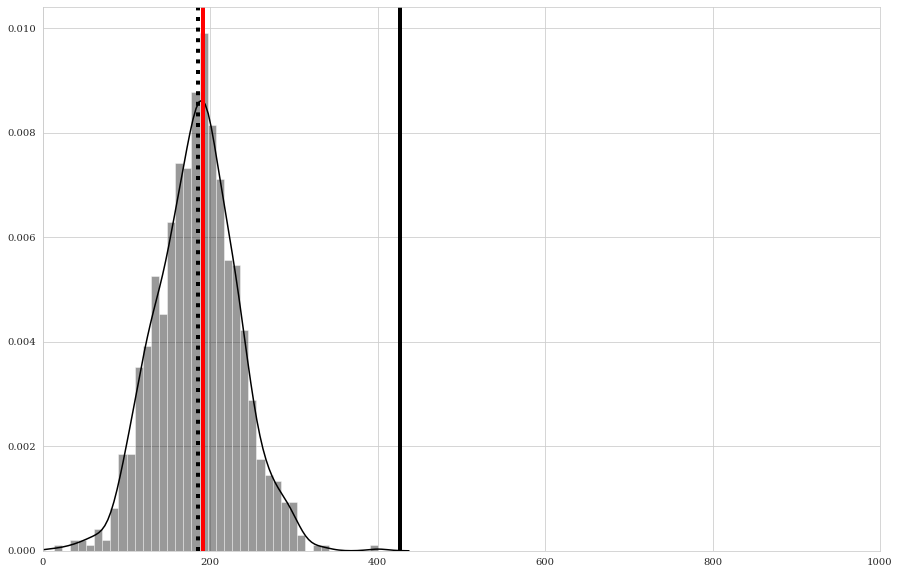

In [42]:
WWRF = utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
pp = np.argwhere(y_tst>350)


nummms = pp[138][0]
guess=np.random.normal(m[nummms],s[nummms],1000)
plt.figure(figsize=[15,10])  
sns.distplot(guess,40,color='k')
plt.axvline(WWRF[nummms],color='r',linewidth=4)
plt.axvline(y_tst[nummms],color='k',linewidth=4)
plt.axvline((m[nummms]),color='k',linestyle=':',linewidth=4)
plt.xlim([0,1000])
plt.show()

## Rank Histogram

computing ranks
computing ties
making figure... takes FOREVER


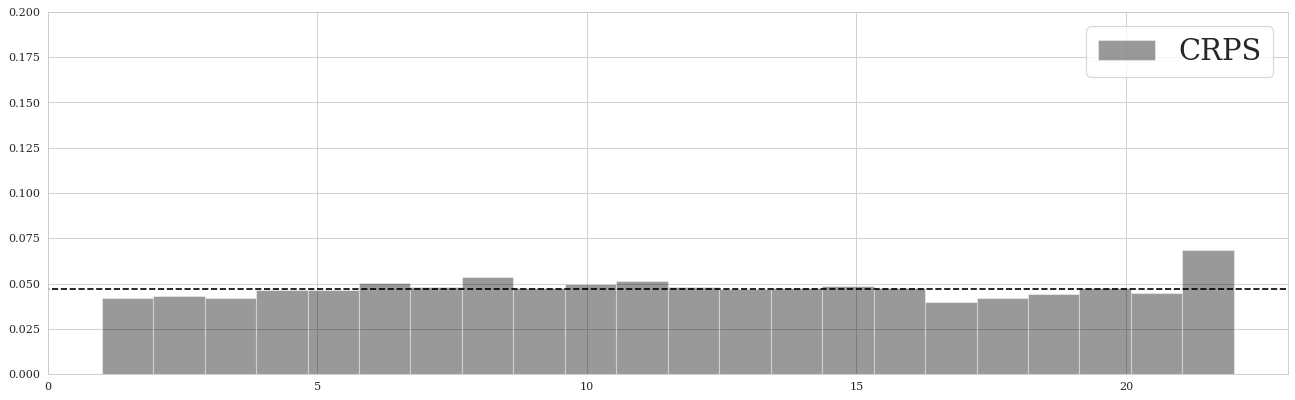

In [44]:
Thresher = 250 #thresh to stratify on. 
rr2 = ranker(yAl[mAl>Thresher],np.transpose(sssAl[mAl>Thresher]))

print('making figure... takes FOREVER')
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,density=True,bins=22,alpha=0.4,label='CRPS',color='k')
plt.plot([-10,80],[0.047,0.047],'k--')
plt.legend(fontsize=26)
plt.ylim([0,0.2])
plt.xlim([0,23])
# plt.savefig('/glade/scratch/wchapman/Reforecast/models/RankHist_'+fcast+'_ThreshOBS250_ForecastHour.png',dpi = 300,bbox_inches='tight')
plt.show()

## PIT Diagram

...making figure...


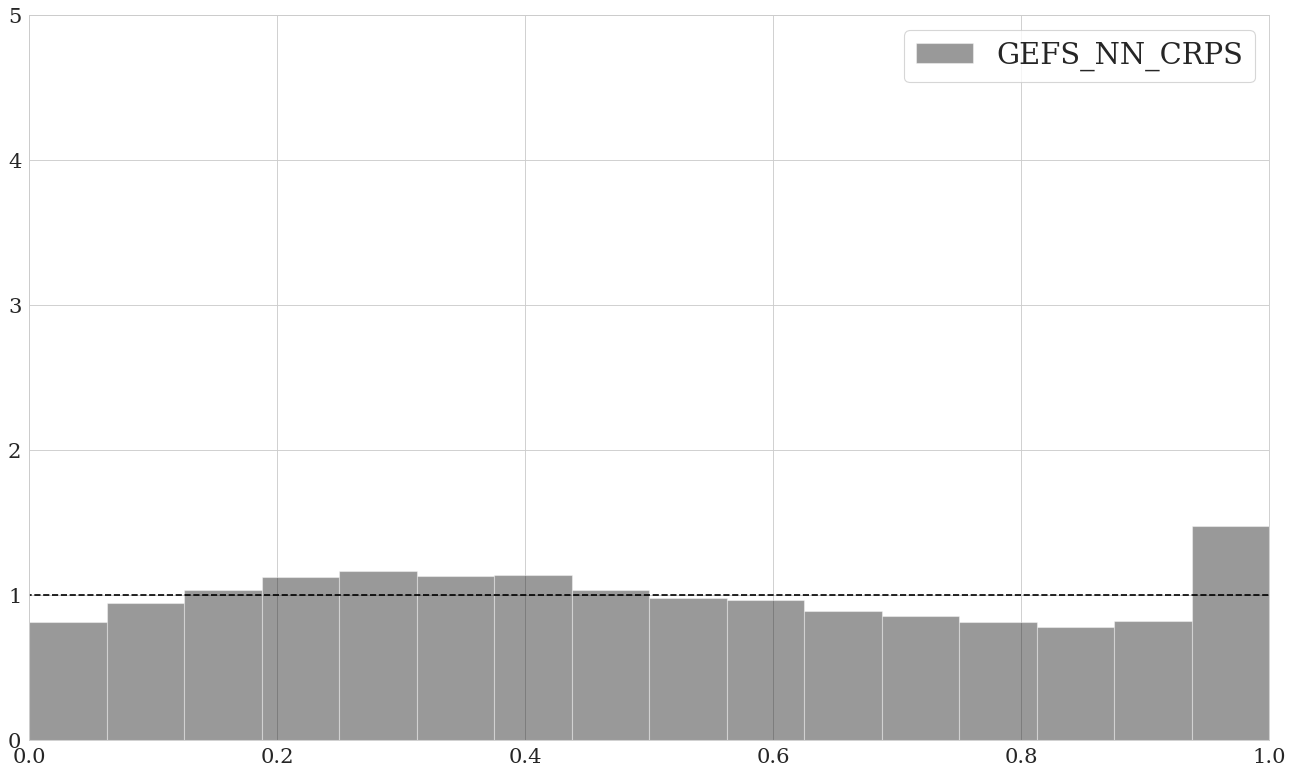

In [45]:
_set = []
_transformed_set = []
 
num_ense=200
for ii in range(yAl.shape[0]):
    texpp = cdf_of_normal(yAl[ii],mAl[ii],sAl[ii])
    _transformed_set.append(texpp)

print('...making figure...')
plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
GefsNN_pit=plt.hist(_transformed_set,density=True,bins=16,alpha=0.4,label='GEFS_NN_CRPS',color='k')
plt.plot([-10,80],[1,1],'k--')
plt.legend(fontsize=26)
plt.ylim([0,5])
plt.xlim([0,1])
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.show()

...binned spread skill...


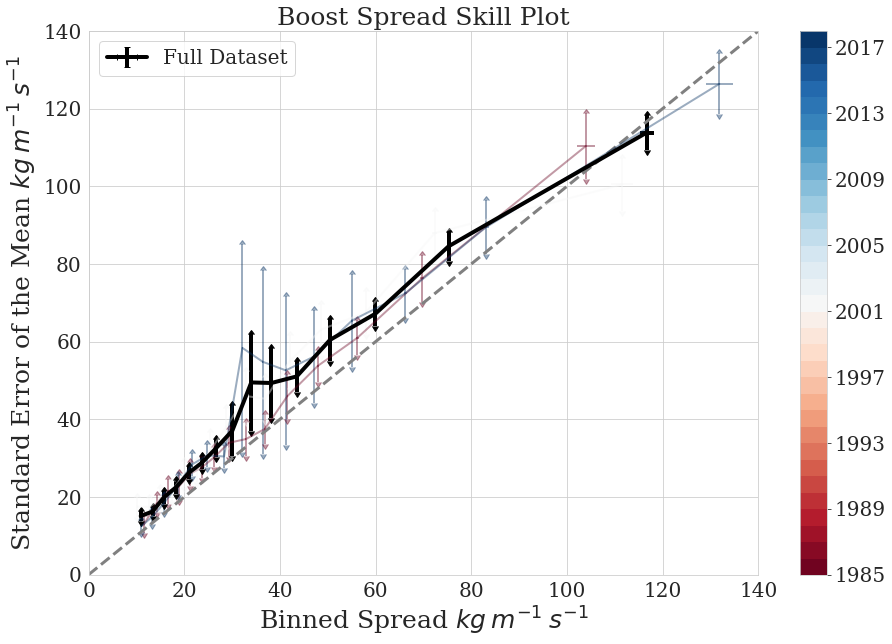

In [46]:
import properscoring as ps
distPPT = (np.squeeze(sAl))
print('...binned spread skill...')
[avgvar_mT,msebin_mT,avgvar_sT,msebin_sT]=spreadskill(mAl,yAl,distPPT,numbins)
# np.savez_compressed('/glade/scratch/wchapman/Reforecast/models/NN_CRPS/F036/Spread_Skill_CRPS.npz',mAl=mAl,yAl=yAl,distPPT=distPPT,
#                     numbins=numbins,avgvar_mA=avgvar_mA,msebin_mA=msebin_mA,avgvar_sA=avgvar_sA,msebin_sA=msebin_sA)

crps_ense = ps.crps_ensemble(np.squeeze(yAl[yAl>250]),sssAl[np.squeeze([yAl>250][0][:]),:])
# np.savez_compressed('/glade/scratch/wchapman/Reforecast/models/NN_CRPS/F036/twCRPS_CRPS.npz',yAl=yAl,sssAl=sssAl,crps_ense=crps_ense)


plt.figure(figsize=[15,10])  # inches
mymap = cm.RdBu
min, max = (1985, 2018)
step = 1
# to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()


evenly_spaced_interval = np.linspace(0, 1, len(All_file_names))
colors = [cm.RdBu(x) for x in evenly_spaced_interval]

# Plotting what I actually want
Z=np.arange(1987,2017,1).tolist()
count=0
for ad,bd,cd,dd,ed in zip(avgvar_mA,msebin_mA,avgvar_sA,msebin_sA,Z):
    # setting rgb color based on z normalized to my range
    plt.errorbar(ad, bd, xerr=3*cd, yerr=3*dd, uplims=True, lolims=True,linewidth=2,color=colors[count],alpha=0.4)
    
    count+=1


    
plt.errorbar(avgvar_mT, msebin_mT, xerr=3*avgvar_sT, yerr=3*msebin_sT, uplims=True, lolims=True,linewidth=4,color='k',alpha=1,label='Full Dataset')
plt.legend(fontsize=20)
plt.plot([0,180],[0,180],linestyle='--',linewidth=3,color=[0.5,0.5,0.5])

plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Boost Spread Skill Plot',fontsize=25)
cb = plt.colorbar(CS3) # using the colorbar info I got from contourf
cb.ax.tick_params(labelsize=20) 
plt.xlim([0,140])
plt.ylim([0,140])

plt.show()

# Compare with GEFS:

In [47]:
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')
#reloading utils after changes:
importlib.reload(utilsProbSS)
importlib.reload(utilsProb)


We are here: /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal


<module 'utilsProb' from '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsProb.py'>

In [49]:
gefs_file_names = sorted([f for f in glob.glob("/glade/scratch/wchapman/GEFS/F048/*8.nc", recursive=True)])
for f in gefs_file_names:
    print(f)

/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc
/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc
/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc


In [50]:
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind,lonind] = utilsProbSS.get_latlon_ind_gefs(latlonfolder)
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])
latsDO.shape


for aa,f in enumerate(gefs_file_names):
    ff = Dataset(f)
    
    if aa==0:
        IVTgefs = ff['IVT'][:].data
        IVTm_gefs = ff['IVTm'][:].data
        latgefs = ff['lat'][:]
        longefs = ff['lon'][:]
    else: 
        IVTgefs = np.concatenate([IVTgefs, ff['IVT'][:].data],axis=0)
        IVTm_gefs = np.concatenate([IVTm_gefs, ff['IVTm'][:].data],axis=0)

IVTens_gefs = np.reshape(np.swapaxes(IVTgefs[:,:,latind,lonind],1,2),[357*144,21])
IVTm_gefs = np.ndarray.flatten(IVTm_gefs[:,latind,lonind])
IVTgefs = IVTgefs[:,:,latind,lonind]
IVTgefsm = np.ndarray.flatten(np.squeeze(np.mean(IVTgefs,axis=1)))
IVTgefss = np.ndarray.flatten(np.squeeze(np.std(IVTgefs,axis=1)))

# RAW Rank Histogram

computing ranks
computing ties
making figure... takes FOREVER


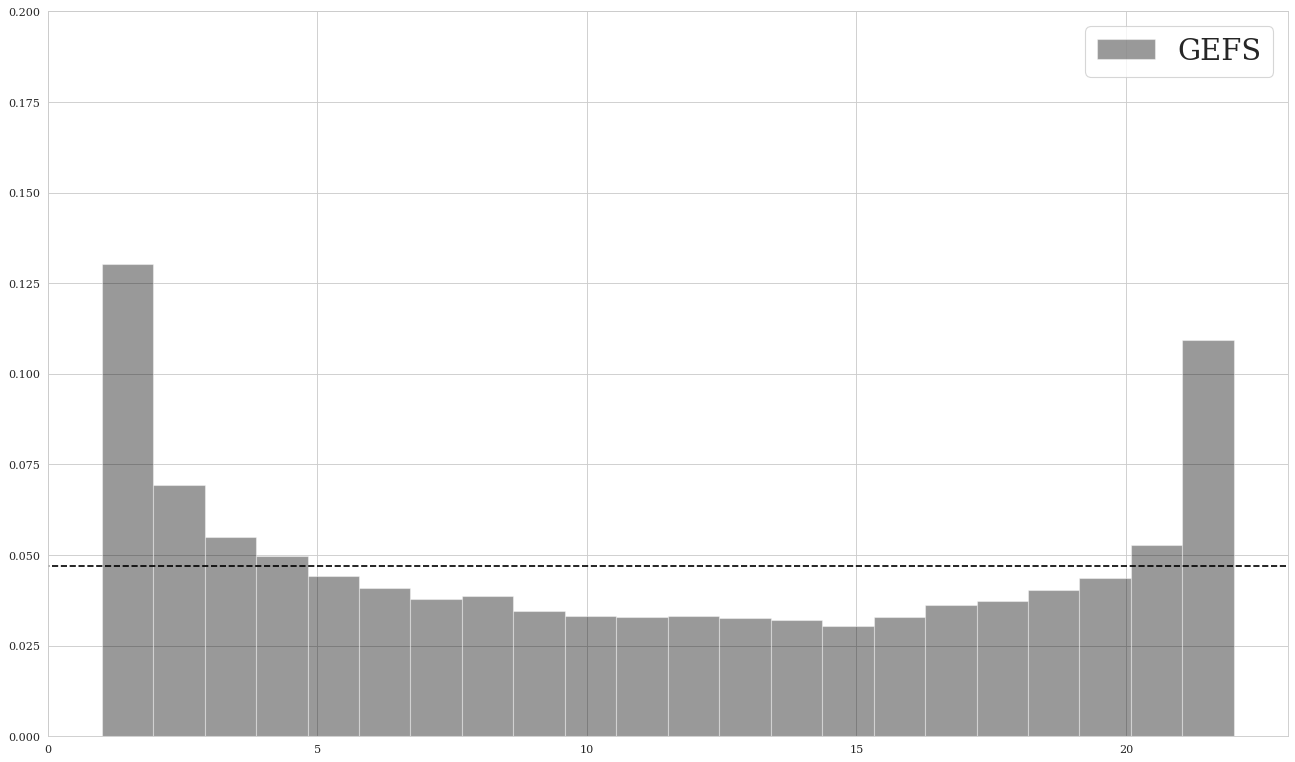

In [51]:
Thresher = 20 #thresh to stratify on. 

rr2 = ranker(IVTm_gefs[IVTgefsm>Thresher],np.transpose(IVTens_gefs[IVTgefsm>Thresher]))

print('making figure... takes FOREVER')
plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,density=True,bins=22,alpha=0.4,label='GEFS',color='k')
plt.plot([-10,80],[0.047,0.047],'k--')
plt.legend(fontsize=26)
plt.ylim([0,0.2])
plt.xlim([0,23])
# plt.savefig('/glade/scratch/wchapman/Reforecast/models/RankHist_'+fcast+'_ThreshOBS250_ForecastHour.png',dpi = 300,bbox_inches='tight')
plt.show()

# RAW PIT diagram

...making figure...


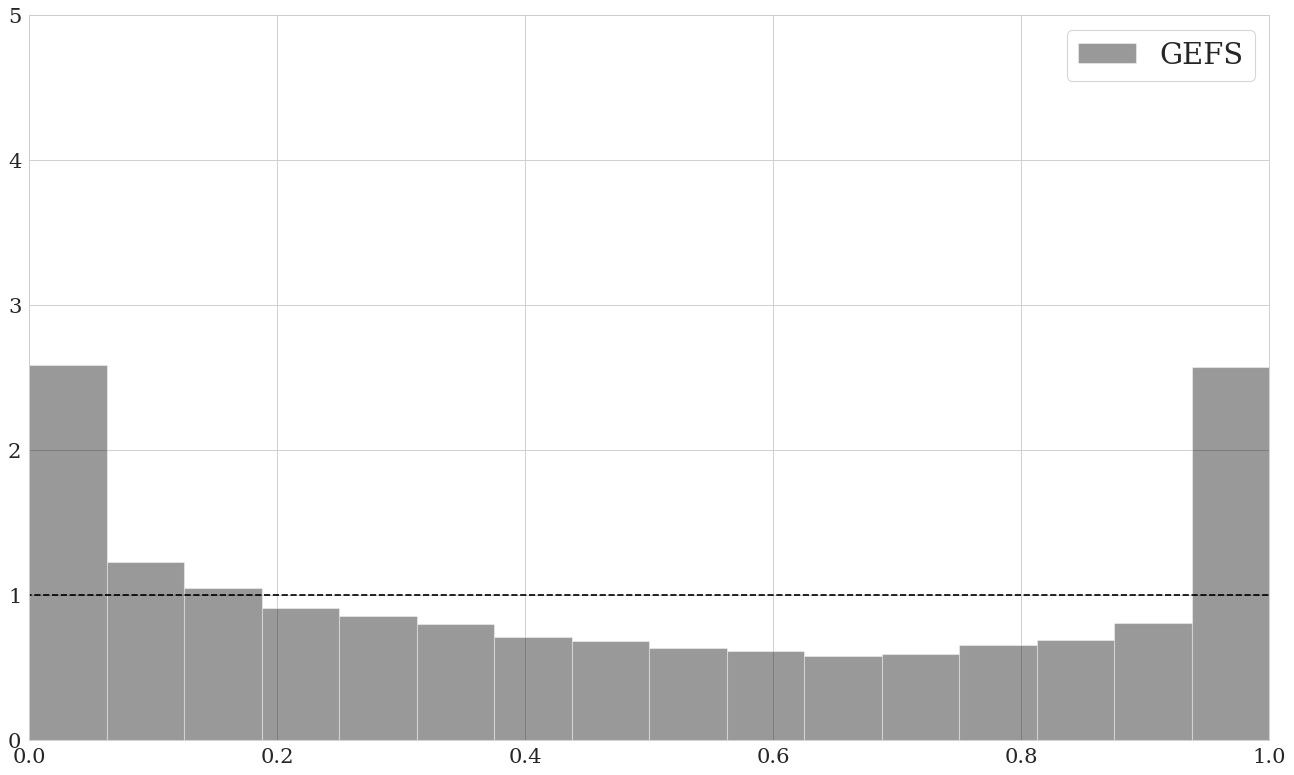

In [52]:
_set = []
_transformed_set = []
 
num_ense=200
for ii in range(IVTm_gefs.shape[0]):
    texpp = cdf_of_normal(IVTm_gefs[ii],IVTgefsm[ii],IVTgefss[ii])
    _transformed_set.append(texpp)
   
print('...making figure...')
plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
gefsPIT = plt.hist(_transformed_set,density=True,bins=16,alpha=0.4,label='GEFS',color='k')
plt.plot([-10,80],[1,1],'k--')
plt.legend(fontsize=26)
plt.ylim([0,5])
plt.xlim([0,1])
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.show()

In [53]:
ff

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(116), ensemble(21), lat(61), lon(25)
    variables(dimensions): float64 time(time), float64 lat(lat), float64 lon(lon), float64 IVT(time,ensemble,lat,lon), float64 IVTm(time,lat,lon)
    groups: 

# Leave one out Mean and Variance Correct GEFS

In [150]:
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')
#reloading utils after changes:
importlib.reload(utilsProbSS)
importlib.reload(utilsProb)

gefs_file_names = sorted([f for f in glob.glob("/glade/scratch/wchapman/GEFS/F048/*8.nc", recursive=True)])
for f in gefs_file_names:
    print(f)
    
    
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind,lonind] = utilsProbSS.get_latlon_ind_gefs(latlonfolder)
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])
latsDO.shape



for bigcount, bb in enumerate(range(0,len(gefs_file_names))):

    allinds = np.arange(len(gefs_file_names))
    val_fil_name = [gefs_file_names[allinds[bb]]]
    rest = np.delete(allinds,[bb])
    train_fil_name = np.array(gefs_file_names)[rest].tolist()
        
    print('#################################################')
    print('training:',train_fil_name)
    print('validating:',val_fil_name)
    print('#################################################')
    
    for aa,f in enumerate(train_fil_name):
        ff = Dataset(f)
    
        if aa==0:
            IVTgefs = ff['IVT'][:].data
            IVTm_gefs = ff['IVTm'][:].data
        else: 
            IVTgefs = np.concatenate([IVTgefs, ff['IVT'][:].data],axis=0)
            IVTm_gefs = np.concatenate([IVTm_gefs, ff['IVTm'][:].data],axis=0)
            
    IVTgefsm = np.mean(IVTgefs,axis=1);
    IVTgefsv = np.var(IVTgefs,axis=1);
    IVTgefsv = np.mean(IVTgefsv[:,latind,lonind],axis=0) #<s^2> 
    
    print('Training IVT shape:',IVTm_gefs.shape)
    print('...Gathering Training...')
    MeanErrorGEFS = np.zeros(len(latind))
    ErrVarEnseMeanTrainingGEFS = np.zeros(len(latind))
    
    for rr in range(len(latind)):
        MeanErrorGEFS[rr] = np.mean(IVTgefsm[:,latind[rr],lonind[rr]]- IVTm_gefs[:,latind[rr],lonind[rr]],axis=0)
        ErrVarEnseMeanTrainingGEFS[rr] =np.var(IVTgefsm[:,latind[rr],lonind[rr]] - IVTm_gefs[:,latind[rr],lonind[rr]])
    
    datf=Dataset(val_fil_name[0])
    IVTgefs_pp = datf['IVT'][:].data
    IVTmgefs_pp = datf['IVTm'][:].data
    
    IVTgefs_ppm = np.mean(IVTgefs_pp,axis=1)
    IVTgefs_ppv = np.var(IVTgefs_pp,axis=1)
    
    for rr in range(len(latind)):
        IVTgefs_ppm[:,latind[rr],lonind[rr]] = IVTgefs_ppm[:,latind[rr],lonind[rr]]-MeanErrorGEFS[rr];                             #debiased forecast.
        IVTgefs_ppv[:,latind[rr],lonind[rr]] = (IVTgefs_ppv[:,latind[rr],lonind[rr]]/IVTgefsv[rr])*ErrVarEnseMeanTrainingGEFS[rr]  #variance corrected forecast. 
    
    
    if bigcount == 0:
        IVT_ppm_gefs = np.ndarray.flatten(IVTgefs_ppm[:,latind,lonind])
        IVT_ppv_gefs = np.ndarray.flatten(IVTgefs_ppv[:,latind,lonind])
        IVTm_pp_gefs = np.ndarray.flatten(IVTmgefs_pp[:,latind,lonind]) 
    else: 
        IVT_ppm_gefs = np.concatenate([IVT_ppm_gefs,np.ndarray.flatten(IVTgefs_ppm[:,latind,lonind])],axis=0)
        IVT_ppv_gefs = np.concatenate([IVT_ppv_gefs,np.ndarray.flatten(IVTgefs_ppv[:,latind,lonind])],axis=0)
        IVTm_pp_gefs = np.concatenate([IVTm_pp_gefs,np.ndarray.flatten(IVTmgefs_pp[:,latind,lonind])],axis=0)
        
print('...done...')

# IVTens_gefs = np.reshape(np.swapaxes(IVTgefs[:,:,latind,lonind],1,2),[np.swapaxes(IVTgefs[:,:,latind,lonind],1,2).shape[0]*np.swapaxes(IVTgefs[:,:,latind,lonind],1,2).shape[1],21])
# IVTm_gefs = np.ndarray.flatten(IVTm_gefs[:,latind,lonind])
# IVTgefs = IVTgefs[:,:,latind,lonind]

We are here: /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal
/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc
/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc
/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc
#################################################
training: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc', '/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc']
#################################################
Training IVT shape: (237, 61, 25)
...Gathering Training...
#################################################
training: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc', '/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc']
#################################################
Training IVT shape: (236, 61, 25)
...Gathering Training...
#################################################
tra

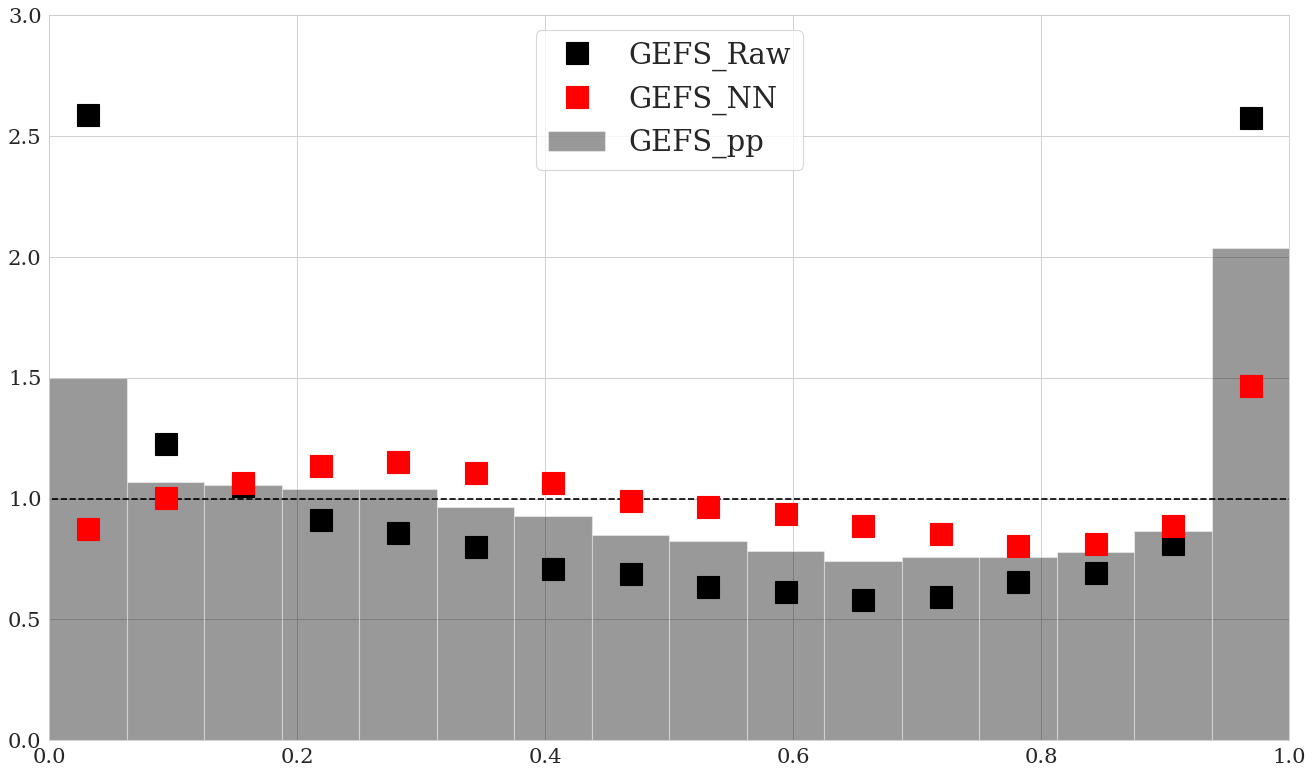

In [156]:
_set = []
_transformed_set = []
 
num_ense=200
for ii in range(IVTm_pp_gefs.shape[0]):
    texpp = cdf_of_normal(IVTm_pp_gefs[ii],IVT_ppm_gefs[ii],np.sqrt(IVT_ppv_gefs[ii]))
    _transformed_set.append(texpp)

plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
GEFSmv_pp=plt.hist(_transformed_set,density=True,bins=16,alpha=0.4,label='GEFS_pp',color='k')
plt.plot()
plt.plot([-10,80],[1,1],'k--')
plt.plot(gefsPIT[1][1:]-(gefsPIT[1][1]-gefsPIT[1][0])/2,gefsPIT[0],'ks',markersize=20,label='GEFS_Raw')
plt.plot(GefsNN_pit[1][1:]-(GefsNN_pit[1][1]-GefsNN_pit[1][0])/2,GefsNN_pit[0],'rs',markersize=20,label='GEFS_NN')

plt.legend(fontsize=26)
plt.ylim([0,3])
plt.xlim([0,1])
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.show()

...making figure...


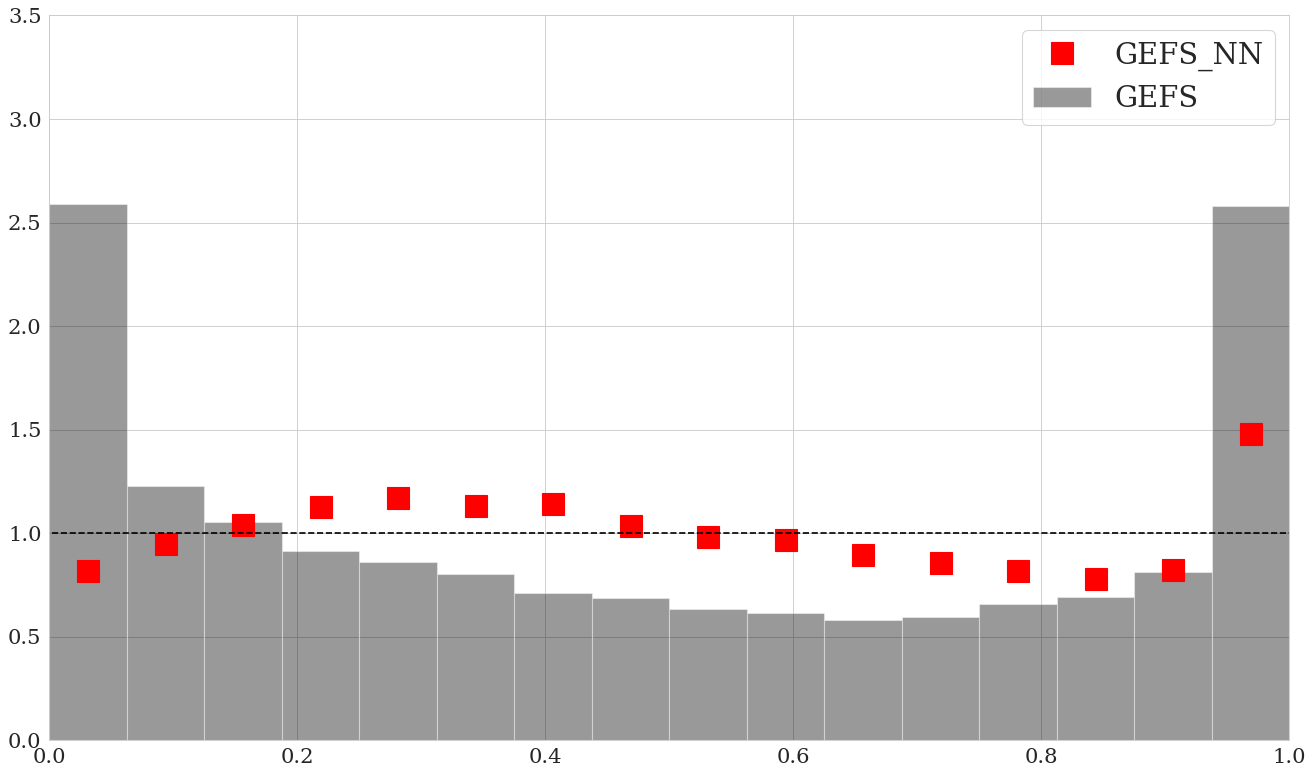

In [54]:
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind,lonind] = utilsProbSS.get_latlon_ind_gefs(latlonfolder)
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])
latsDO.shape


for aa,f in enumerate(gefs_file_names):
    ff = Dataset(f)
    
    if aa==0:
        IVTgefs = ff['IVT'][:].data
        IVTm_gefs = ff['IVTm'][:].data
        latgefs = ff['lat'][:]
        longefs = ff['lon'][:]
    else: 
        IVTgefs = np.concatenate([IVTgefs, ff['IVT'][:].data],axis=0)
        IVTm_gefs = np.concatenate([IVTm_gefs, ff['IVTm'][:].data],axis=0)

IVTens_gefs = np.reshape(np.swapaxes(IVTgefs[:,:,latind,lonind],1,2),[357*144,21])
IVTm_gefs = np.ndarray.flatten(IVTm_gefs[:,latind,lonind])
IVTgefs = IVTgefs[:,:,latind,lonind]
IVTgefsm = np.ndarray.flatten(np.squeeze(np.mean(IVTgefs,axis=1)))
IVTgefss = np.ndarray.flatten(np.squeeze(np.std(IVTgefs,axis=1)))
_set = []
_transformed_set = []
 
num_ense=200
for ii in range(IVTm_gefs.shape[0]):
    texpp = cdf_of_normal(IVTm_gefs[ii],IVTgefsm[ii],IVTgefss[ii])
    _transformed_set.append(texpp)

print('...making figure...')
plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
gefsPIT = plt.hist(_transformed_set,density=True,bins=16,alpha=0.4,label='GEFS',color='k')
# plt.plot(GEFSmv_pp[1][1:]-(GEFSmv_pp[1][1]-GEFSmv_pp[1][0])/2,GEFSmv_pp[0],'ks',markersize=20,label='GEFS_MV')
plt.plot(GefsNN_pit[1][1:]-(GefsNN_pit[1][1]-GefsNN_pit[1][0])/2,GefsNN_pit[0],'rs',markersize=20,label='GEFS_NN')
plt.plot([-10,80],[1,1],'k--')
plt.legend(fontsize=26)
plt.ylim([0,3.5])
plt.xlim([0,1])
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.show()

# Save predictions from WY 2016, 2017, 2018 in the same file. 
For: GEFS_raw, GEFS_nn, GEFS_mv

IVTm shape: (51408,)
IVT mean shape: (51408,)
IVT std shape: (51408,)


/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


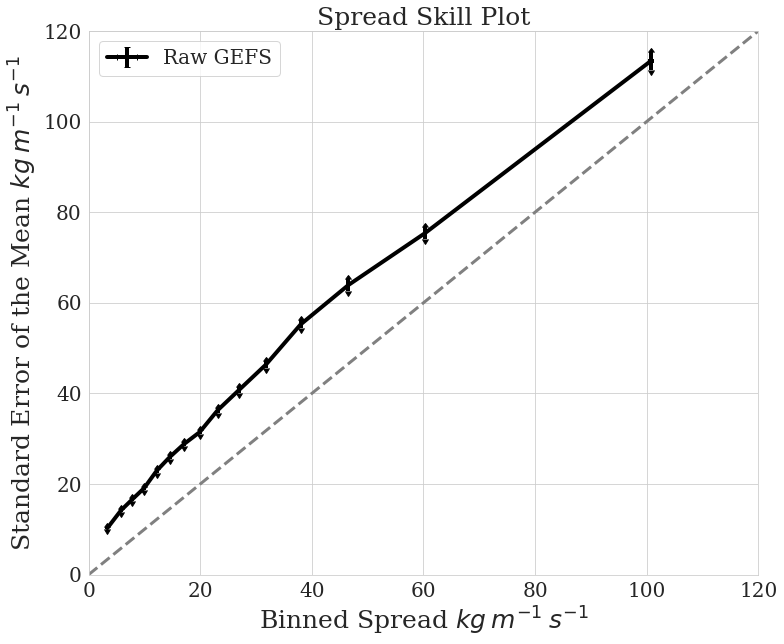

In [55]:
# GEFS_raw:
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind,lonind] = utilsProbSS.get_latlon_ind_gefs(latlonfolder)
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])
latsDO.shape


for aa,f in enumerate(gefs_file_names):
    ff = Dataset(f)
    
    if aa==0:
        IVTgefs = ff['IVT'][:].data
        IVTm_gefs = ff['IVTm'][:].data
        latgefs = ff['lat'][:]
        longefs = ff['lon'][:]
    else: 
        IVTgefs = np.concatenate([IVTgefs, ff['IVT'][:].data],axis=0)
        IVTm_gefs = np.concatenate([IVTm_gefs, ff['IVTm'][:].data],axis=0)

IVTens_gefs = np.reshape(np.swapaxes(IVTgefs[:,:,latind,lonind],1,2),[357*144,21])
IVTm_gefs = np.ndarray.flatten(IVTm_gefs[:,latind,lonind])
IVTgefs = IVTgefs[:,:,latind,lonind]
IVTgefsm = np.ndarray.flatten(np.squeeze(np.mean(IVTgefs,axis=1)))
IVTgefss = np.ndarray.flatten(np.squeeze(np.std(IVTgefs,axis=1)))

newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/GEFS_out/'
print('IVTm shape:', IVTm_gefs.shape)
print('IVT mean shape:', IVTgefsm.shape)
print('IVT std shape:', IVTgefss.shape)
np.savez(newdir+'RAW_gefs.npz',lat=latgefs,lon=longefs,IVTgefsm=IVTgefsm,IVTgefss=IVTgefss,IVTm_gefs=IVTm_gefs)

[avgvar_m,msebin_m,avgvar_s,msebin_s]=spreadskill(IVTgefsm,IVTm_gefs,IVTgefss,numbins)

plt.figure(figsize=[12,10])  # inches

plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color='K',linewidth=4,label='Raw GEFS')
plt.legend(fontsize=20)
plt.plot([0,180],[0,180],linestyle='--',linewidth=3,color=[0.5,0.5,0.5])

plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)


plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Spread Skill Plot',fontsize=25)
cb.ax.tick_params(labelsize=20) 
plt.xlim([0,120])
plt.ylim([0,120])

plt.show()

In [187]:
#Mean variance correction: 
print('We are here:',os.getcwd())
os.chdir('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/')
#reloading utils after changes:
importlib.reload(utilsProbSS)
importlib.reload(utilsProb)

gefs_file_names = sorted([f for f in glob.glob("/glade/scratch/wchapman/GEFS/F048/*8.nc", recursive=True)])
for f in gefs_file_names:
    print(f)
    
    
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
[latsDO,lonsDO,latind,lonind] = utilsProbSS.get_latlon_ind_gefs(latlonfolder)
latind = np.array(latind[:rang])
lonind = np.array(lonind[:rang])
latsDO = np.array(latsDO[:rang])
lonsDO = np.array(lonsDO[:rang])
latsDO.shape



for bigcount, bb in enumerate(range(0,len(gefs_file_names))):

    allinds = np.arange(len(gefs_file_names))
    val_fil_name = [gefs_file_names[allinds[bb]]]
    rest = np.delete(allinds,[bb])
    train_fil_name = np.array(gefs_file_names)[rest].tolist()
        
    print('#################################################')
    print('training:',train_fil_name)
    print('validating:',val_fil_name)
    print('#################################################')
    
    for aa,f in enumerate(train_fil_name):
        ff = Dataset(f)
    
        if aa==0:
            IVTgefs = ff['IVT'][:].data
            IVTm_gefs = ff['IVTm'][:].data
        else: 
            IVTgefs = np.concatenate([IVTgefs, ff['IVT'][:].data],axis=0)
            IVTm_gefs = np.concatenate([IVTm_gefs, ff['IVTm'][:].data],axis=0)
            
    IVTgefsm = np.mean(IVTgefs,axis=1);
    IVTgefsv = np.var(IVTgefs,axis=1);
    IVTgefsv = np.mean(IVTgefsv[:,latind,lonind],axis=0) #<s^2> 
    
    print('Training IVT shape:',IVTm_gefs.shape)
    print('...Gathering Training...')
    MeanErrorGEFS = np.zeros(len(latind))
    ErrVarEnseMeanTrainingGEFS = np.zeros(len(latind))
    
    for rr in range(len(latind)):
        MeanErrorGEFS[rr] = np.mean(IVTgefsm[:,latind[rr],lonind[rr]]- IVTm_gefs[:,latind[rr],lonind[rr]],axis=0)
        ErrVarEnseMeanTrainingGEFS[rr] =np.var(IVTgefsm[:,latind[rr],lonind[rr]] - IVTm_gefs[:,latind[rr],lonind[rr]])
    
    datf=Dataset(val_fil_name[0])
    IVTgefs_pp = datf['IVT'][:].data
    IVTmgefs_pp = datf['IVTm'][:].data
    
    IVTgefs_ppm = np.mean(IVTgefs_pp,axis=1)
    IVTgefs_ppv = np.var(IVTgefs_pp,axis=1)
    
    for rr in range(len(latind)):
        IVTgefs_ppm[:,latind[rr],lonind[rr]] = IVTgefs_ppm[:,latind[rr],lonind[rr]]-MeanErrorGEFS[rr];                             #debiased forecast.
        IVTgefs_ppv[:,latind[rr],lonind[rr]] = (IVTgefs_ppv[:,latind[rr],lonind[rr]]/IVTgefsv[rr])*ErrVarEnseMeanTrainingGEFS[rr]  #variance corrected forecast. 
    
    
    if bigcount == 0:
        IVT_ppm_gefs = np.ndarray.flatten(IVTgefs_ppm[:,latind,lonind])
        IVT_ppv_gefs = np.ndarray.flatten(IVTgefs_ppv[:,latind,lonind])
        IVTm_pp_gefs = np.ndarray.flatten(IVTmgefs_pp[:,latind,lonind]) 
    else: 
        IVT_ppm_gefs = np.concatenate([IVT_ppm_gefs,np.ndarray.flatten(IVTgefs_ppm[:,latind,lonind])],axis=0)
        IVT_ppv_gefs = np.concatenate([IVT_ppv_gefs,np.ndarray.flatten(IVTgefs_ppv[:,latind,lonind])],axis=0)
        IVTm_pp_gefs = np.concatenate([IVTm_pp_gefs,np.ndarray.flatten(IVTmgefs_pp[:,latind,lonind])],axis=0)
        
print('...done...')

newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/GEFS_out/'
print('IVTm shape:', IVTm_pp_gefs.shape)
print('IVT mean shape:', IVT_ppm_gefs.shape)
print('IVT std shape:', IVT_ppv_gefs.shape)

np.savez(newdir+'Mean_Variance_PP_gefs.npz',lat=latgefs,lon=longefs,IVTgefsm=IVT_ppm_gefs,IVTgefss=np.sqrt(IVT_ppv_gefs),IVTm_gefs=IVTm_pp_gefs)

We are here: /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal
/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc
/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc
/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc
#################################################
training: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc', '/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc']
#################################################
Training IVT shape: (237, 61, 25)
...Gathering Training...
#################################################
training: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048.nc', '/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048.nc']
#################################################
Training IVT shape: (236, 61, 25)
...Gathering Training...
#################################################
tra

## Neural Network: 

#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
before shape: (16704, 1)
deleting: (0,) indices
after shape: (16704, 1)
before shape test: (17424, 1)
deleting test: (0,) indices
after shape tst: (17424, 1)
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 1)

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in double_scalars
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in exp
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: overflow encountered in exp


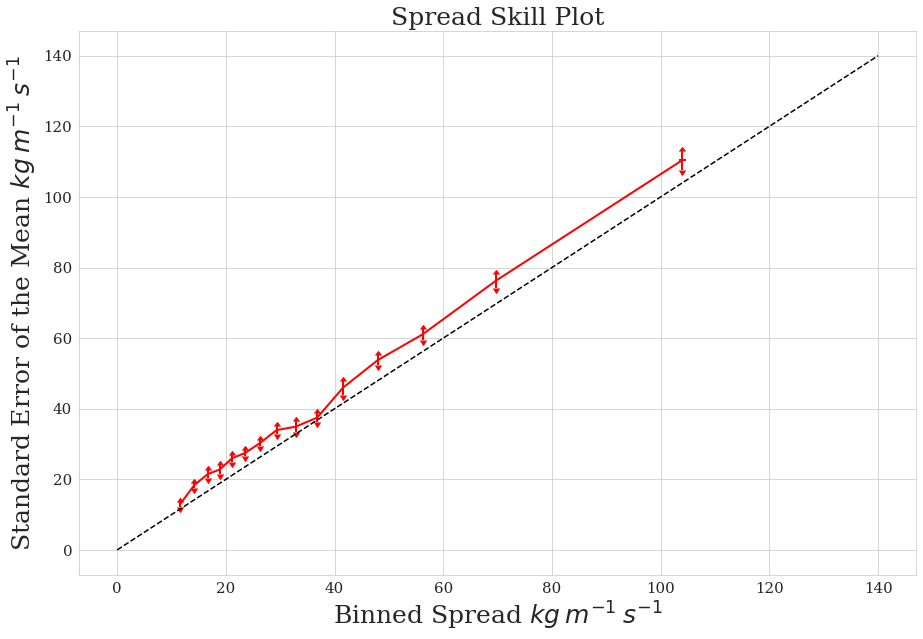

47.93208534149528
48.227893042074164
47.92668065407352
48.176001077214366
-0.7197823746436143
2.2366464821223246
#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
before shape: (17280, 1)
deleting: (0,) indices
after shape: (17280, 1)
before shape test: (16704, 1)
deleting test: (0,) indices
after shape tst: (16704, 1)
...Encoding Stations...
...done...
In shape:  1
Out shape:  1
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in exp
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in double_scalars
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: overflow encountered in exp


...binned spread skill...


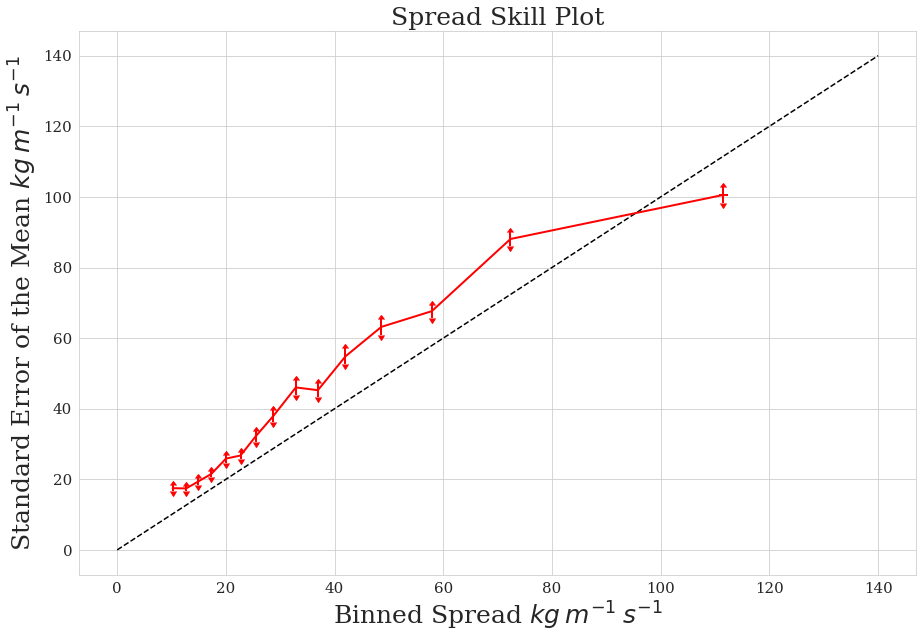

50.98045965418667
51.98058330576514
50.80311783234957
51.974729431153946
-4.2485862430417
0.7800906139240453
#################################################
testing: ['/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc']
validating: ['/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2018_GEFS_F048_mem1.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2016_GEFS_F048_mem1.nc"...
Reading data from: "/glade/scratch/wchapman/GEFS/F048/WY_2017_GEFS_F048_mem1.nc"...
before shape: (34704, 1)
deleting: (0,) indices
after shape: (34704, 1)
before shape test: (17280, 1)
deleting test: (0,) indices
after shape tst: (17280, 1)
...Encoding Stations...
...done...
In shape

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in exp
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:433: RuntimeWarning: overflow encountered in double_scalars
/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: overflow encountered in exp


...binned spread skill...


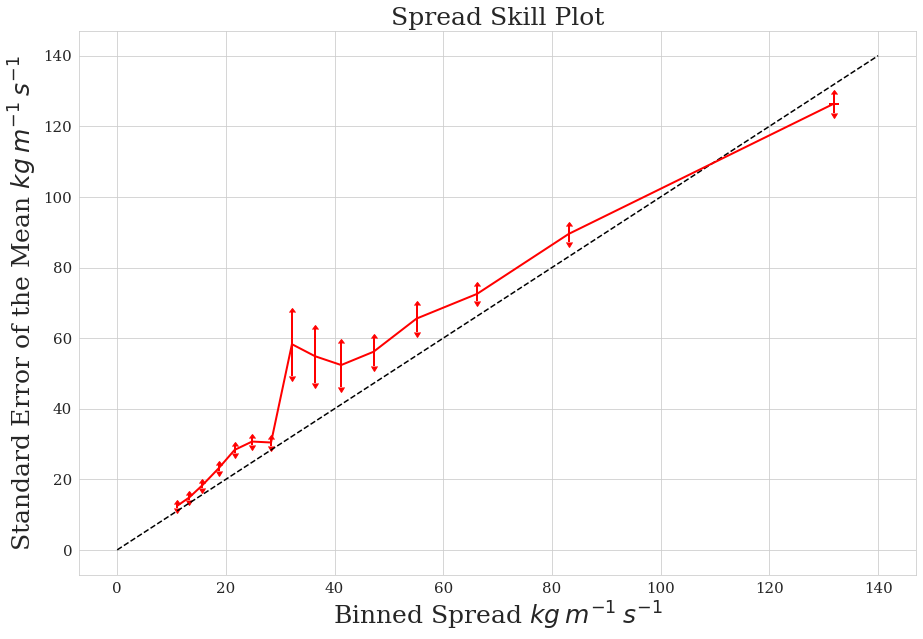

57.75917024129378
58.39030448115307
57.70245829391543
58.282115763327475
-2.558916528867911
3.552835424258177
IVTm shape: (51408,)
IVT mean shape: (51408,)
IVT std shape: (51408,)


In [59]:
All_file_names
ense = 21
numbins = 15
allinds = np.arange(len(All_file_names))


avgvar_mA = np.zeros([len(All_file_names),numbins])
msebin_mA = np.zeros([len(All_file_names),numbins])
avgvar_sA = np.zeros([len(All_file_names),numbins])
msebin_sA = np.zeros([len(All_file_names),numbins])

mAl =np.array([])
sAl =np.array([])
yAl =np.array([])

for ddfa, bb in enumerate(range(0,len(All_file_names))):

    if bb == (len(All_file_names)-1):
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[0]]]
        val_fil_name = [All_file_names[allinds[-1]]]
        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    else:
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[bb+1]]]
        val_fil_name = [All_file_names[allinds[bb]]]
        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('testing:',test_fil_name)
    print('validating:',val_fil_name)
    print('#################################################')
    
    num_samps_train = utilsProbSS_Mem1.count_samps(train_fil_name,latind,lonind)
    num_samps_val = utilsProbSS_Mem1.count_samps(val_fil_name,latind,lonind)

    print('...gathering data...')
    aa = utilsProbSS_Mem1.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x = adf[0]
    y = adf[1]
    
    ######## load testing ##############################################
    xpred = utilsProbSS_Mem1.read_image_file(test_fil_name[0],latind,lonind)
    x_tst = np.reshape(xpred['predictor_matrix'],[xpred['predictor_matrix'].shape[0]*xpred['predictor_matrix'].shape[1],xpred['predictor_matrix'].shape[2]])
    y_tst = np.reshape(xpred['target_matrix'],[xpred['target_matrix'].shape[0]*xpred['target_matrix'].shape[1]])
    x_tst = utilsProbSS.normalize_images(x_tst,xpred['predictor_names'],norm_dict)[0]
    y_tst = utilsProbSS.normalize_images_targ(y_tst,xpred['target_name'],norm_dict_targ)[0]
    y_tst = np.expand_dims(y_tst,axis=1)
    ######## load testing ##############################################
    
    #remove x and y where x ==0 
    rmind = np.where(utilsProbSS_Mem1.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
    print('before shape:',y.shape)
    print('deleting:',rmind[0].shape,'indices')
    x = np.delete(x,rmind[0],0)
    y = np.delete(y,rmind[0],0)
    print('after shape:',y.shape)
    
    
    rmind = np.where(utilsProbSS_Mem1.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)

    print('...Encoding Stations...')

    SUMID = np.unique(x[:,1]+x[:,2])
    #station ID integers 
    stID = np.zeros([x.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x[:,1]+x[:,2]==un)
        stID[mats,:] = int(jj)
    stID=stID.astype(int)

    #station ID integers 
    stID_tst = np.zeros([x_tst.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(np.around(10000*np.round((x_tst[:,1]+x_tst[:,2]),4)).astype(int)==np.around(10000*np.round(un,4)).astype(int))[0]
        stID_tst[mats,:] = int(jj)
    stID_tst=stID_tst.astype(int)
    print('...done...')

    x=x[:,:1]
    x_tst=x_tst[:,:1]
    
    ### Model Build #### 
    
    in_shape = x.shape[1]
    print('In shape: ',in_shape)
    out_shape = 1
    print('Out shape: ',out_shape)
    
    max_id = np.max(stID)
    model = build_emb_model(in_shape,2,[30,40],2,max_id,compile=True)
    model.summary()    
    valyr= val_fil_name[0].split('_GEFS')[0]
    valyr =valyr.split('_')[1]
    
    tstyr= test_fil_name[0].split('_GEFS')[0]
    tstyr =tstyr.split('_')[1]    
    newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/Gefs_ONLYTHREE_Mem1_'+tstyr
    Wsave_name = newdir+'/cpf_CRPS_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    print("... loading....",Wsave_name)
    
    ### CHANGE THIS FOR PRODUCTION RUNS ###########
    model.load_weights(Wsave_name)
    ### CHANGE THIS FOR PRODUCTION RUNS ###########
    
    yhat = model([x_tst,stID_tst])
    
    m = yhat[:,0].numpy()
    m2 = yhat[:,0].numpy()
    s = np.abs(yhat[:,1].numpy())
    mm = yhat[:,0].numpy()
        
#     m = (utilsProbSS.denormalize_images_targ(m,'IVT',norm_dict))
#     m2 = (utilsProbSS.denormalize_images_targ(m2,'IVT',norm_dict))
    
    WWRF = utilsProbSS_Mem1.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
    y_tst = (utilsProbSS_Mem1.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))
    
    
    #form ensembles 
    m_All = np.zeros(len(m))
    sss_All = np.zeros([len(m),ense])
    s_All = np.zeros(len(m))
    
    
    for ii in range(len(m)):
        sss = np.random.normal(m[ii],s[ii],ense)
        sln=np.std(sss)
        mln=np.mean(sss)
        [mln,sln]=lognstat(m[ii],s[ii])
        s_All[ii]=s[ii]
        m_All[ii]=m[ii]
        sss_All[ii,:] =(sss) 

    m = m_All
    m[np.isnan(m)]=0
    s=s_All
    s[np.isnan(m)]=0
    
    y_tst = (y_tst)
    WWRF = (WWRF)
    distPP = s
    
    if ddfa == 0:
        sssAl = sss_All
    else: 
        sssAl = np.concatenate([sssAl,sss_All],axis=0)
    
    mAl = np.append(mAl,np.ndarray.flatten(m))
    yAl = np.append(yAl,np.ndarray.flatten(y_tst))
    sAl = np.append(sAl,np.ndarray.flatten(s))
    
    print('...binned spread skill...')
    [avgvar_m,msebin_m,avgvar_s,msebin_s]=spreadskill(m,y_tst,distPP,numbins)
    
    avgvar_mA[bb,:] = np.squeeze(avgvar_m)
    msebin_mA[bb,:] = np.squeeze(msebin_m)
    avgvar_sA[bb,:] = np.squeeze(avgvar_s)
    msebin_sA[bb,:] = np.squeeze(msebin_s)
    
    plt.figure(figsize=[15,10])  # inches
    plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color='r',linewidth=2)
    plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
    plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Spread Skill Plot',fontsize=25)

    plt.plot([0,140],[0,140],'k--')
    plt.show()
    
    print(rmse(np.expand_dims(m,axis=1),y_tst))
    print(rmse(np.expand_dims(WWRF,axis=1),y_tst))
    print(crmse(np.expand_dims(m,axis=1),y_tst))
    print(crmse(np.expand_dims(WWRF,axis=1),y_tst))
    print(bias(np.expand_dims(m,axis=1),y_tst))
    print(bias(np.expand_dims(WWRF,axis=1),y_tst))
    
newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/GEFS_out/'
print('IVTm shape:', yAl.shape)
print('IVT mean shape:', mAl.shape)
print('IVT std shape:', sAl.shape)

np.savez(newdir+'NN_CRPS_PP_gefs_mem1.npz',lat=lat,lon=lon,IVTgefsm=mAl,IVTgefss=sAl,IVTm_gefs=yAl)

## What's the Total Binned Spread Skill:

In [528]:
print(rmse(np.expand_dims(m,axis=1),y_tst))
print(rmse(np.expand_dims(WWRF,axis=1),y_tst))
print(crmse(np.expand_dims(m,axis=1),y_tst))
print(crmse(np.expand_dims(WWRF,axis=1),y_tst))

45.618907049112735
48.11040715151401
45.572590247978326
47.8142790469515


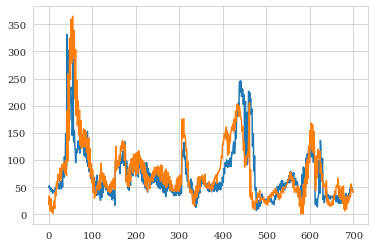

In [527]:
plt.plot(m[0:700])
plt.plot(y_tst[0:700])

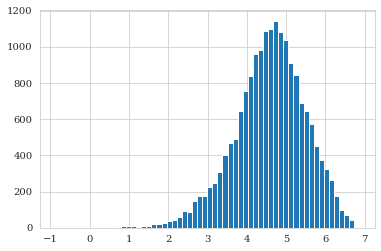

In [529]:
plt.hist(np.log(WWRF),60)
plt.show()

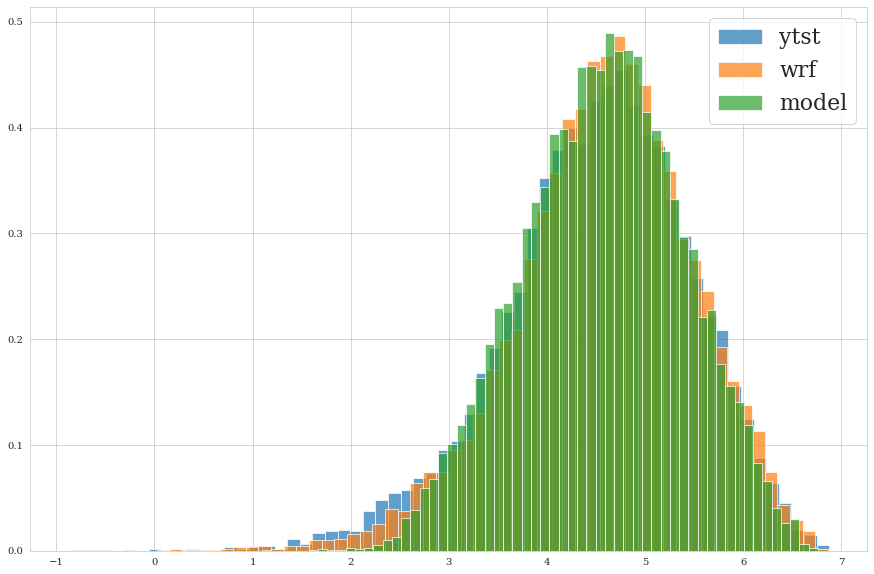

In [530]:
plt.figure(figsize=[15,10])  # inches
plt.hist(np.log(y_tst),60,alpha=0.7,label='ytst',density=True)
plt.hist(np.log(WWRF),60,alpha=0.7,label='wrf',density=True)
plt.hist(np.log(m),60,alpha=0.7,label='model',density=True)
plt.legend(fontsize=22)
plt.show()

In [95]:
import properscoring as ps
distPPT = (np.squeeze(sAl))
print('...binned spread skill...')
[avgvar_mT,msebin_mT,avgvar_sT,msebin_sT]=spreadskill(mAl,yAl,distPPT,numbins)
# np.savez_compressed('/glade/scratch/wchapman/Reforecast/models/NN_CRPS/F036/Spread_Skill_CRPS.npz',mAl=mAl,yAl=yAl,distPPT=distPPT,
#                     numbins=numbins,avgvar_mA=avgvar_mA,msebin_mA=msebin_mA,avgvar_sA=avgvar_sA,msebin_sA=msebin_sA)

crps_ense = ps.crps_ensemble(np.squeeze(yAl[yAl>250]),sssAl[np.squeeze([yAl>250][0][:]),:])
# np.savez_compressed('/glade/scratch/wchapman/Reforecast/models/NN_CRPS/F036/twCRPS_CRPS.npz',yAl=yAl,sssAl=sssAl,crps_ense=crps_ense)

...binned spread skill...


58.12024025080255


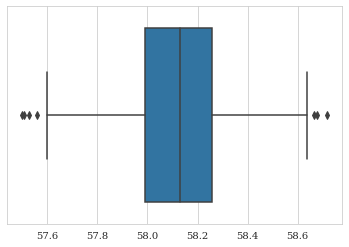

In [97]:
boosty=1000
percy = 0.1

import random

boot_crps=np.zeros([boosty])
for pp in range(boosty):
    toint = random.sample(range(0, len(crps_ense)), int(len(crps_ense)*percy))
    boot_crps[pp] = np.mean(crps_ense[toint])
    
print(np.mean(boot_crps))
ax = sns.boxplot(boot_crps)

60.747659012085215


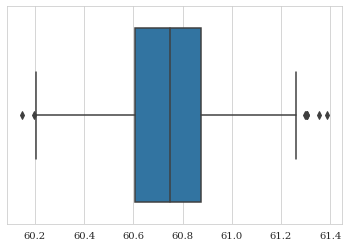

In [40]:
FCN = np.load('/glade/scratch/wchapman/Reforecast/models/NN_FCN/F036/twCRPS_FCN.npz')
crps_ense_fcn = FCN['crps_ense']

boosty=1000
percy = 0.1

import random

boot_crps_fcn=np.zeros([boosty])
for pp in range(boosty):
    toint = random.sample(range(0, len(crps_ense_fcn)), int(len(crps_ense_fcn)*percy))
    boot_crps_fcn[pp] = np.mean(crps_ense_fcn[toint])
    
print(np.mean(boot_crps_fcn))  
ax = sns.boxplot(boot_crps_fcn)

In [64]:
ale['yAl'].shape

(3416446,)

In [63]:
np.unique(ale['yAl']).shape

(2613573,)

58.43728857197058


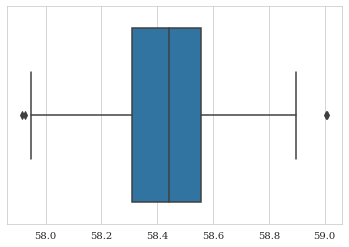

In [46]:
ale = np.load('/glade/scratch/wchapman/Reforecast/models/NN_Aleatoric/F036/twCRPS_Aleatoric.npz')
crps_ense_ale = ale['crps_ense']

boosty=1000
percy = 0.1

import random

boot_crps_ale=np.zeros([boosty])
for pp in range(boosty):
    toint = random.sample(range(0, len(crps_ense_ale)), int(len(crps_ense_ale)*percy))
    boot_crps_ale[pp] = np.mean(crps_ense_ale[toint])
    
print(np.mean(boot_crps_ale))  
ax = sns.boxplot(boot_crps_ale)

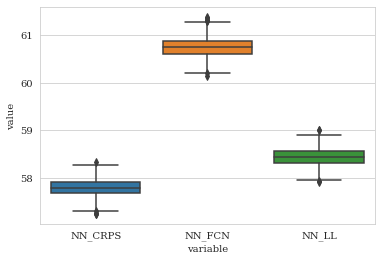

In [48]:
pdcrps = pd.DataFrame({'NN_CRPS':boot_crps,'NN_FCN':boot_crps_fcn,'NN_LL':boot_crps_ale})
sns.boxplot(x="variable", y="value", data=pd.melt(pdcrps))
plt.show()

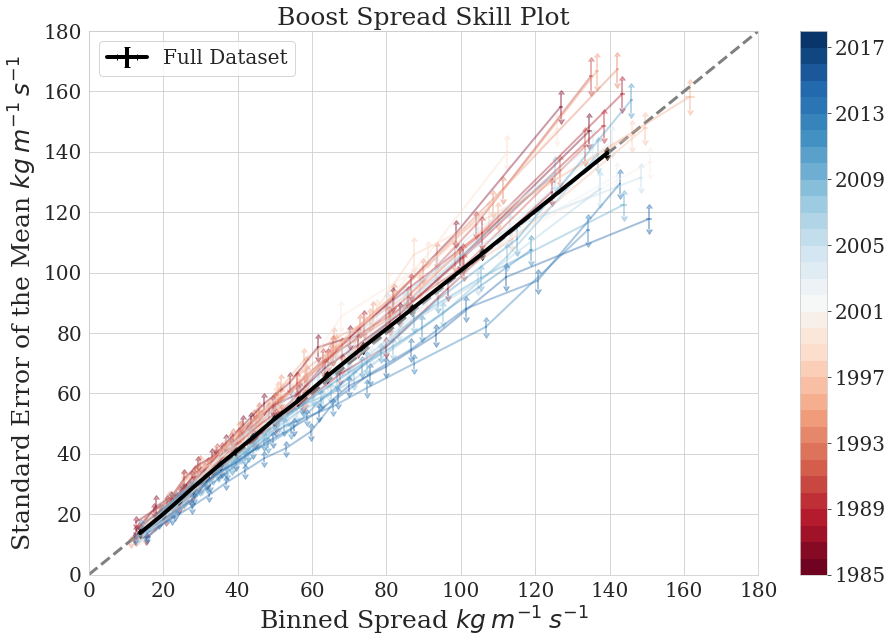

In [98]:
plt.figure(figsize=[15,10])  # inches
mymap = cm.RdBu
min, max = (1985, 2018)
step = 1
# to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()


evenly_spaced_interval = np.linspace(0, 1, len(All_file_names)-1)
colors = [cm.RdBu(x) for x in evenly_spaced_interval]

# Plotting what I actually want
Z=np.arange(1987,2017,1).tolist()
count=0
for ad,bd,cd,dd,ed in zip(avgvar_mA,msebin_mA,avgvar_sA,msebin_sA,Z):
    # setting rgb color based on z normalized to my range
    plt.errorbar(ad, bd, xerr=3*cd, yerr=3*dd, uplims=True, lolims=True,linewidth=2,color=colors[count],alpha=0.4)
    
    count+=1


    
plt.errorbar(avgvar_mT, msebin_mT, xerr=3*avgvar_sT, yerr=3*msebin_sT, uplims=True, lolims=True,linewidth=4,color='k',alpha=1,label='Full Dataset')
plt.legend(fontsize=20)
plt.plot([0,180],[0,180],linestyle='--',linewidth=3,color=[0.5,0.5,0.5])

plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Boost Spread Skill Plot',fontsize=25)
cb = plt.colorbar(CS3) # using the colorbar info I got from contourf
cb.ax.tick_params(labelsize=20) 
plt.xlim([0,180])
plt.ylim([0,180])

plt.show()

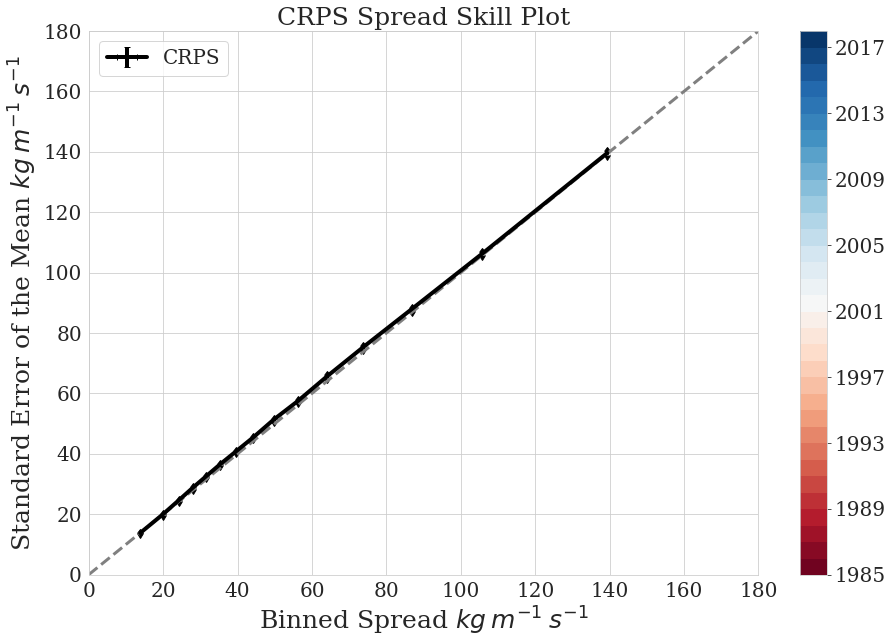

In [99]:
plt.figure(figsize=[15,10])  # inches
mymap = cm.RdBu
min, max = (1985, 2018)
step = 1
# to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()


evenly_spaced_interval = np.linspace(0, 1, len(All_file_names)-1)
colors = [cm.RdBu(x) for x in evenly_spaced_interval]

plt.errorbar(avgvar_mT, msebin_mT, xerr=3*avgvar_sT, yerr=3*msebin_sT, uplims=True, lolims=True,linewidth=4,color='k',alpha=1,label='CRPS')
plt.legend(fontsize=20)
plt.plot([0,180],[0,180],linestyle='--',linewidth=3,color=[0.5,0.5,0.5])

plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('CRPS Spread Skill Plot',fontsize=25)
cb = plt.colorbar(CS3) # using the colorbar info I got from contourf
cb.ax.tick_params(labelsize=20) 
plt.xlim([0,180])
plt.ylim([0,180])

plt.show()

## Is this trend true? 

In [11]:
All_file_names
numbins = 20
allinds = np.arange(len(All_file_names))

mlAg =dict()
mlAt =dict()
mlAe =dict()
msebin_mA = np.zeros([len(All_file_names),numbins])
msebin_sA = np.zeros([len(All_file_names),numbins])

for bb in range(0,len(All_file_names)):
    allinds = np.arange(len(All_file_names))
#     test_fil_name = [All_file_names[allinds[bb+1]]]
    val_fil_name = [All_file_names[allinds[bb]]]
    
    rest = np.delete(allinds,[bb])
    train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('validatiing:',val_fil_name)
    print('#################################################')
    
    num_samps_val = utilsProb.count_samps(val_fil_name)

    print('...gathering data...')
    
    aa = utilsProbSS.deep_learning_generator_ss_mv(val_fil_name, num_samps_val*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x_tst = adf[0]
    y_tst = adf[1]

    rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)
    
    y_tst = (utilsProbSS.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))
    x_tst = (utilsProbSS.denormalize_images_targ(x_tst,'IVT',norm_dict))
    [msebin_m,msebin_s,mlt,mlg,mle]=stnd_error_mean(x_tst[:,0],y_tst,numbins)
    msebin_mA[bb,:] = np.squeeze(msebin_m)
    msebin_sA[bb,:] = np.squeeze(msebin_s)
    
    valyr= val_fil_name[0].split('_500mb')[0]
    valyr =valyr.split('_')[2]
    mlAt[valyr] = mlt
    mlAg[valyr] = mlg
    mlAe[valyr] = mle


#################################################
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1985_500mb.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1985_500mb.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1985_500mb.nc"...
before shape test: (103320, 1)
deleting test: (0,) indices
after shape tst: (103320, 1)
...getting max...
#################################################
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1986_500mb.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1986_500mb.nc"...
...gathering data...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1986_500mb.nc"...
before shape test: (103320, 1)
deleting test: (0,) indices
after shape tst: (103320, 1)
...getting max...
########

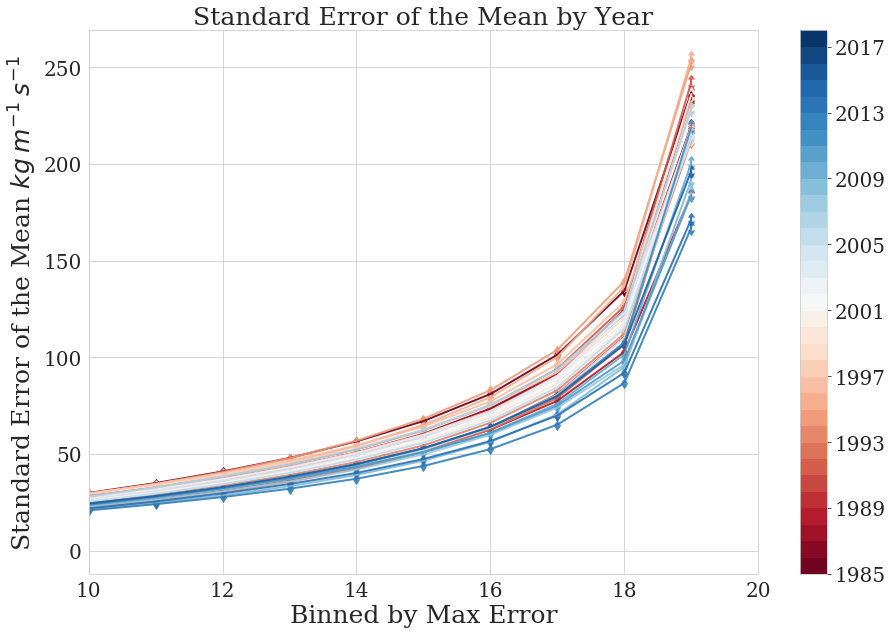

In [13]:
plt.figure(figsize=[15,10])  # inches

mymap = cm.RdBu
min, max = (1985, 2018)
step = 1
# to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

evenly_spaced_interval = np.linspace(0, 1, len(All_file_names)-1)
colors = [cm.RdBu(x) for x in evenly_spaced_interval]

# Plotting what I actually want
Z=np.arange(1987,2017,1).tolist()
count=0
for ad,bd,cd in zip(msebin_mA,msebin_sA,Z):
    # setting rgb color based on z normalized to my range
    plt.errorbar(np.arange(0,20),ad,yerr=bd, uplims=True, lolims=True,linewidth=2,color=colors[count],alpha=0.9)
#     plt.plot([0,140],[0,140],'k--')
    count+=1

    
plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned by Max Error',fontsize=25)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Standard Error of the Mean by Year',fontsize=25)
cb = plt.colorbar(CS3) # using the colorbar info I got from contourf
cb.ax.tick_params(labelsize=20) 
plt.xlim([10,20])
plt.show()

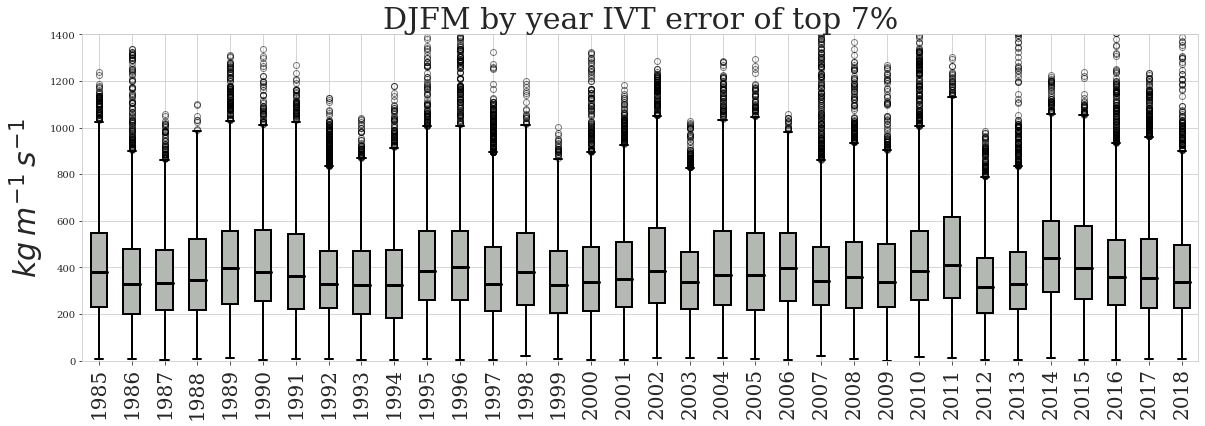

In [15]:
data_to_plot=[mlAt['1985'],mlAt['1986'],mlAt['1987'],mlAt['1988'],mlAt['1989'],mlAt['1990'],
              mlAt['1991'],mlAt['1992'],mlAt['1993'],mlAt['1994'],
             mlAt['1995'],mlAt['1996'],mlAt['1997'],mlAt['1998'],
             mlAt['1999'],mlAt['2000'],mlAt['2001'],mlAt['2002'],
             mlAt['2003'],mlAt['2004'],mlAt['2005'],mlAt['2006'],
             mlAt['2007'],mlAt['2008'],mlAt['2009'],mlAt['2010'],
             mlAt['2011'],mlAt['2012'],mlAt['2013'],mlAt['2014'],
             mlAt['2015'],mlAt['2016'],mlAt['2017'],mlAt['2018']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([0,1400])
ax.set_xticklabels(mlAt.keys(),fontsize=20, rotation='vertical')
# ax.set_yticklabels(np.arange(0,1000,0.5),fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM by year IVT error of top 7%',fontsize=30)
plt.ylabel('$kg \:  m^{-1} \: s^{-1}$',fontsize=30)

# fname = '/Users/will/Desktop/Haupt/CRPS_MJO_Center.png'
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()

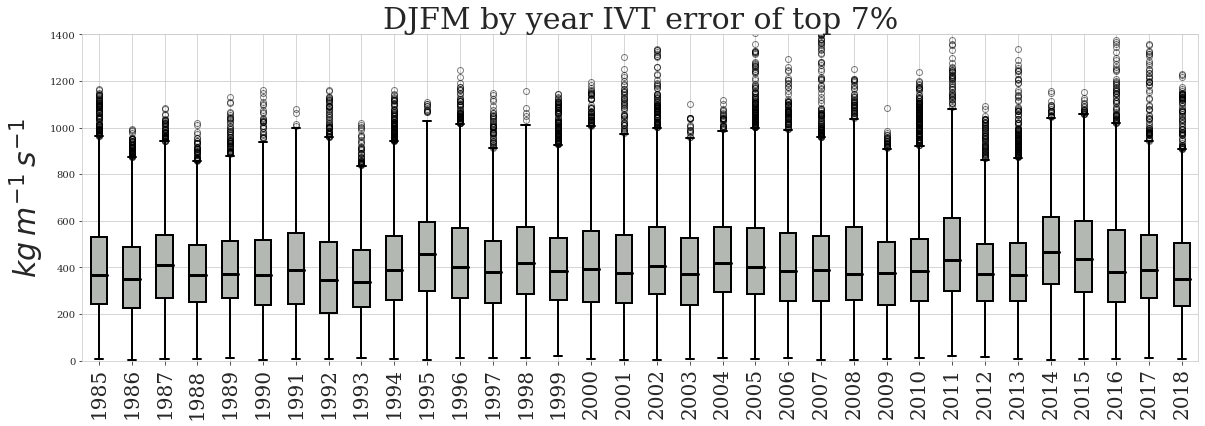

In [16]:
data_to_plot=[mlAg['1985'],mlAg['1986'],mlAg['1987'],mlAg['1988'],mlAg['1989'],mlAg['1990'],
              mlAg['1991'],mlAg['1992'],mlAg['1993'],mlAg['1994'],
             mlAg['1995'],mlAg['1996'],mlAg['1997'],mlAg['1998'],
             mlAg['1999'],mlAg['2000'],mlAg['2001'],mlAg['2002'],
             mlAg['2003'],mlAg['2004'],mlAg['2005'],mlAg['2006'],
             mlAg['2007'],mlAg['2008'],mlAg['2009'],mlAg['2010'],
             mlAg['2011'],mlAg['2012'],mlAg['2013'],mlAg['2014'],
             mlAg['2015'],mlAg['2016'],mlAg['2017'],mlAg['2018']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([0,1400])
ax.set_xticklabels(mlAg.keys(),fontsize=20, rotation='vertical')
# ax.set_yticklabels(np.arange(0,1000,0.5),fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM by year IVT error of top 7%',fontsize=30)
plt.ylabel('$kg \:  m^{-1} \: s^{-1}$',fontsize=30)

# fname = '/Users/will/Desktop/Haupt/CRPS_MJO_Center.png'
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()

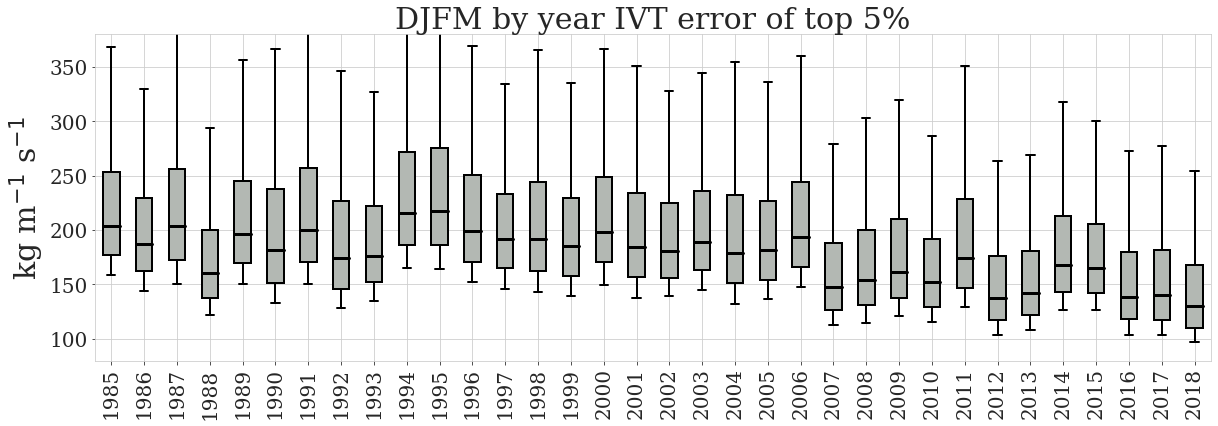

In [23]:
data_to_plot=[mlAe['1985'],mlAe['1986'],mlAe['1987'],mlAe['1988'],mlAe['1989'],mlAe['1990'],
              mlAe['1991'],mlAe['1992'],mlAe['1993'],mlAe['1994'],
             mlAe['1995'],mlAe['1996'],mlAe['1997'],mlAe['1998'],
             mlAe['1999'],mlAe['2000'],mlAe['2001'],mlAe['2002'],
             mlAe['2003'],mlAe['2004'],mlAe['2005'],mlAe['2006'],
             mlAe['2007'],mlAe['2008'],mlAe['2009'],mlAe['2010'],
             mlAe['2011'],mlAe['2012'],mlAe['2013'],mlAe['2014'],
             mlAe['2015'],mlAe['2016'],mlAe['2017'],mlAe['2018']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([80,380])
ax.set_xticklabels(mlAg.keys(),fontsize=20, rotation='vertical')
# ax.yticklabels(fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM by year IVT error of top 5%',fontsize=30)
plt.ylabel('kg m$^{-1}$ s$^{-1}$',fontsize=30)
plt.yticks(fontsize=20)
# fname = '/Users/will/Desktop/Haupt/CRPS_MJO_Center.png'
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()

## There is clearly a trend in the model skill....even though this is a reforecast.

if we had a date vector... maybe this will help? This generator gives the forecast time, and an index which ranges a linear trend from -2 to 2 for 1985-->2018

In [ ]:
aa = utilsProbSS.deep_learning_generator_ss_mv_time(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
adf = next(aa)
x = adf[0]
y = adf[1]
timy = adf[2]
timy_ind = adf[3]


In [377]:
len(All_file_names)

34

In [381]:
All_file_names
boostnum = 500 #boost IVT overs this number. 

allinds = np.arange(len(All_file_names))

for bb in range(32,len(All_file_names)-1):
    allinds = np.arange(len(All_file_names))
    test_fil_name = [All_file_names[allinds[bb+1]]]
    val_fil_name = [All_file_names[allinds[bb]]]
    
    rest = np.delete(allinds,[bb,bb+1])
    train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('testing:',test_fil_name)
    print('validatiing:',val_fil_name)
    print('#################################################')
    
    num_samps_train = utilsProb.count_samps(train_fil_name)
    num_samps_val = utilsProb.count_samps(val_fil_name)

    print('...gathering data...')
    aa = utilsProbSS.deep_learning_generator_ss_mv_time(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x = adf[0]
    y = adf[1]
    train_tim=adf[2]
    train_timind=adf[3]
    aa = utilsProbSS.deep_learning_generator_ss_mv_time(val_fil_name, num_samps_val*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x_tst = adf[0]
    y_tst = adf[1]
    tst_tim=adf[2]
    tst_timind=adf[3]

    #remove x and y where x ==0 
    rmind = np.where(utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
    print('before shape:',y.shape)
    print('deleting:',rmind[0].shape,'indices')
    x = np.delete(x,rmind[0],0)
    y = np.delete(y,rmind[0],0)
    print('after shape:',y.shape)
    
    rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)       
    
    
    print('y_tst:',y_tst.shape[0])
    print('x_tst:',x_tst.shape[0])
    
    print('...Encoding Stations...')

    SUMID = np.unique(x[:,6]+x[:,7])
    #station ID integers 
    stID = np.zeros([x.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x[:,6]+x[:,7]==un)
        stID[mats,:] = int(jj)
    stID=stID.astype(int)

    #station ID integers 
    stID_tst = np.zeros([x_tst.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x_tst[:,6]+x_tst[:,7]==un)
        stID_tst[mats,:] = int(jj)
    stID_tst=stID_tst.astype(int)
    print('...done...')

    
    x=x[:,:6]
    x_tst=x_tst[:,:6]
    
    #append a date vector. 
    x = np.concatenate((x,train_timind),axis=1)
    x_tst = np.concatenate((x_tst,tst_timind),axis=1)
    
    ### Model Build #### 
    
    in_shape = x.shape[1]
    print('In shape: ',in_shape)
    out_shape = 1
    print('Out shape: ',out_shape)
    
    max_id = np.max(stID)
    model = build_emb_model(in_shape,out_shape,2,max_id ,compile=True)
    valyr= val_fil_name[0].split('_500mb')[0]
    valyr =valyr.split('_')[2]
    
    tstyr= test_fil_name[0].split('_500mb')[0]
    tstyr =tstyr.split('_')[2]
    Wsave_name = '/glade/scratch/wchapman/Reforecast/models/NN_Bayes/' +fcast+'/cpf_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    
    print(Wsave_name)
    
    modsave = tf.keras.callbacks.ModelCheckpoint(Wsave_name, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min',include_optimizer=False)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001,verbose=1)
    er_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
    net_in = tf.keras.layers.Input(shape=(in_shape))
    
    #train model
    histss = model.fit([x,stID], y,validation_data=([x_tst,stID_tst],y_tst), epochs=20,batch_size=100 ,verbose=True,callbacks=[modsave,reduce_lr,er_stop]);
    
    hist_df = pd.DataFrame(histss.history) 

   
    # or save to csv: 
    hist_csv_file = '/glade/work/wchapman/AnEn/CNN/Reforecast/fithist_'+ valyr+'_test_'+tstyr+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
    break

#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F036/test/F036_WY_2018_500mb.nc']
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/validate/F036_WY_2017_500mb.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1985_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1986_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1987_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1988_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1989_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1990_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1991_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1992_500mb.nc"

3262900/3263104 [============================>.] - ETA: 0s - loss: 657.9322
Epoch 00001: val_loss improved from inf to 3.11049, saving model to /glade/scratch/wchapman/Reforecast/models/NN_Bayes/F036/cpf_val_2017_test_2018.ckpt
3263104/3263104 [==============================] - 104s 32us/sample - loss: 657.8912 - val_loss: 3.1105
Epoch 2/20
3262100/3263104 [============================>.] - ETA: 0s - loss: 1.3856
Epoch 00002: val_loss improved from 3.11049 to 0.24983, saving model to /glade/scratch/wchapman/Reforecast/models/NN_Bayes/F036/cpf_val_2017_test_2018.ckpt
3263104/3263104 [==============================] - 88s 27us/sample - loss: 1.3853 - val_loss: 0.2498
Epoch 3/20
3262500/3263104 [============================>.] - ETA: 0s - loss: 0.2527
Epoch 00003: val_loss improved from 0.24983 to 0.03106, saving model to /glade/scratch/wchapman/Reforecast/models/NN_Bayes/F036/cpf_val_2017_test_2018.ckpt
3263104/3263104 [==============================] - 97s 30us/sample - loss: 0.2527 - v

##### This generator gives you the time vector as a string and also characterizes the time as a number betweeen -2 and 2 from 1985 --> 2018

#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F036/test/F036_WY_2018_500mb.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F036/validate/F036_WY_2017_500mb.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1985_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1986_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1987_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1988_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1989_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1990_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1991_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1992_500mb.nc".

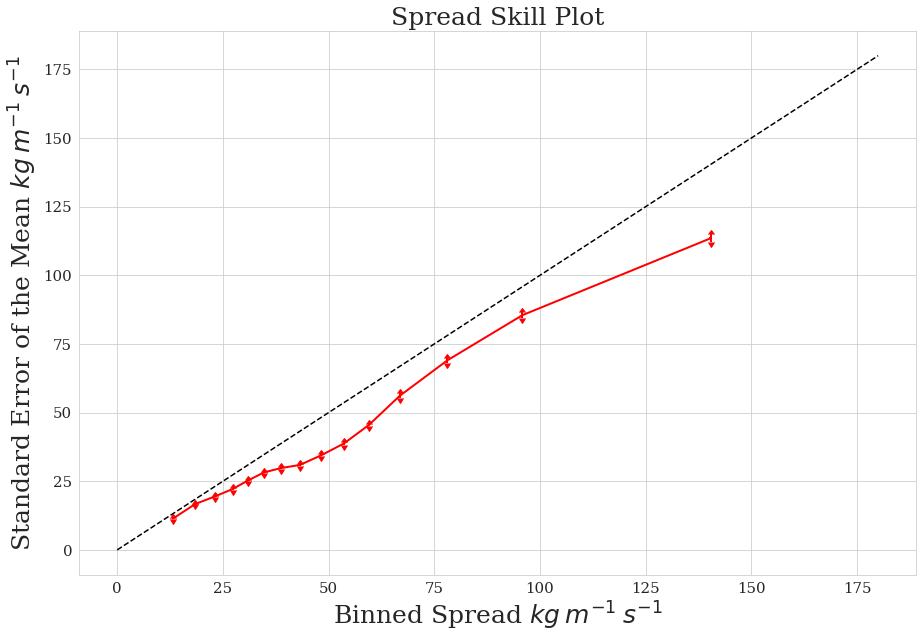

49.950377194909464
51.08285165121412
49.234491326527696
50.88791473630188
8.426460976828992
4.458542


In [385]:
All_file_names
ense = 200
numbins = 15
allinds = np.arange(len(All_file_names))


avgvar_mA = np.zeros([len(All_file_names)-1,numbins])
msebin_mA = np.zeros([len(All_file_names)-1,numbins])
avgvar_sA = np.zeros([len(All_file_names)-1,numbins])
msebin_sA = np.zeros([len(All_file_names)-1,numbins])

mAl =np.array([])
sAl =np.array([])
yAl =np.array([])

for ddfa, bb in enumerate(range(32,len(All_file_names)-1)):
    allinds = np.arange(len(All_file_names))
    test_fil_name = [All_file_names[allinds[bb+1]]]
    val_fil_name = [All_file_names[allinds[bb]]]
    
    rest = np.delete(allinds,[bb,bb+1])
    train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('testing:',test_fil_name)
    print('validating:',val_fil_name)
    print('#################################################')
    
    num_samps_train = utilsProb.count_samps(train_fil_name)
    num_samps_val = utilsProb.count_samps(val_fil_name)

    print('...gathering data...')
    aa = utilsProbSS.deep_learning_generator_ss_mv_time(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x = adf[0]
    y = adf[1]
    train_tim=adf[2]
    train_timind=adf[3]
    aa = utilsProbSS.deep_learning_generator_ss_mv_time(val_fil_name, num_samps_val*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
    adf = next(aa)
    x_tst = adf[0]
    y_tst = adf[1]
    tst_tim=adf[2]
    tst_timind=adf[3]

    #remove x and y where x ==0 
    rmind = np.where(utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
    print('before shape:',y.shape)
    print('deleting:',rmind[0].shape,'indices')
    x = np.delete(x,rmind[0],0)
    y = np.delete(y,rmind[0],0)
    print('after shape:',y.shape)
    
    rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)       
    
    
    print('y_tst:',y_tst.shape[0])
    print('x_tst:',x_tst.shape[0])
    
    print('...Encoding Stations...')

    SUMID = np.unique(x[:,6]+x[:,7])
    #station ID integers 
    stID = np.zeros([x.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x[:,6]+x[:,7]==un)
        stID[mats,:] = int(jj)
    stID=stID.astype(int)

    #station ID integers 
    stID_tst = np.zeros([x_tst.shape[0],1])
    for jj,un in enumerate(SUMID):
        mats = np.where(x_tst[:,6]+x_tst[:,7]==un)
        stID_tst[mats,:] = int(jj)
    stID_tst=stID_tst.astype(int)
    print('...done...')

    
    x=x[:,:6]
    x_tst=x_tst[:,:6]
    
    #append a date vector. 
    x = np.concatenate((x,train_timind),axis=1)
    x_tst = np.concatenate((x_tst,tst_timind),axis=1)
    
    ### Model Build #### 
    
    in_shape = x.shape[1]
    print('In shape: ',in_shape)
    out_shape = 1
    print('Out shape: ',out_shape)
    
    max_id = np.max(stID)
    model = build_emb_model(in_shape,out_shape,2,max_id ,compile=True)
    valyr= val_fil_name[0].split('_500mb')[0]
    valyr =valyr.split('_')[2]
    
    tstyr= test_fil_name[0].split('_500mb')[0]
    tstyr =tstyr.split('_')[2]
    Wsave_name = '/glade/scratch/wchapman/Reforecast/models/NN_Bayes/' +fcast+'/cpf_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    print("... loading....",Wsave_name)
    
    ### CHANGE THIS FOR PRODUCTION RUNS ###########
    model.load_weights(Wsave_name)
    ### CHANGE THIS FOR PRODUCTION RUNS ###########
    
    yhat = model([x_tst,stID_tst])

    m = np.zeros([x_tst.shape[0],1])
    for pp in range(ense):
        m += yhat.mean().numpy()
    m = m/ense

    m = (utilsProbSS.denormalize_images_targ(m,'IVT',norm_dict))

    s = np.zeros([x_tst.shape[0],1])
    for pp in range(ense):
        s += yhat.stddev().numpy()
    s = s/ense

    mm = np.zeros([x_tst.shape[0],1])
    for pp in range(ense):
        mm += yhat.mean().numpy()
    mm = mm/ense
    
    if ddfa >=20:
        print('scaled')
        ssu = (utilsProbSS.denormalize_images_targ(mm,'IVT',norm_dict)+(s*norm_dict['IVT'][1]))
        ssd = (utilsProbSS.denormalize_images_targ(mm,'IVT',norm_dict)-(s*norm_dict['IVT'][1]))
    else: 
        ssu = (utilsProbSS.denormalize_images_targ(mm,'IVT',norm_dict)+(s*norm_dict['IVT'][1]))
        ssd = (utilsProbSS.denormalize_images_targ(mm,'IVT',norm_dict)-(s*norm_dict['IVT'][1]))
    y_tst = (utilsProbSS.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))
    WWRF = utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
    distPP = (np.squeeze(ssu) - np.squeeze(m))
    
    
    mAl = np.append(mAl,np.ndarray.flatten(m))
    yAl = np.append(yAl,np.ndarray.flatten(y_tst))
    sAl = np.append(sAl,np.ndarray.flatten(ssu))
    
    print('...binned spread skill...')
    [avgvar_m,msebin_m,avgvar_s,msebin_s]=spreadskill(m,y_tst,distPP,numbins)
    
    avgvar_mA[bb,:] = np.squeeze(avgvar_m)
    msebin_mA[bb,:] = np.squeeze(msebin_m)
    avgvar_sA[bb,:] = np.squeeze(avgvar_s)
    msebin_sA[bb,:] = np.squeeze(msebin_s)
    
    plt.figure(figsize=[15,10])  # inches
    plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color='r',linewidth=2)
    plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
    plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Spread Skill Plot',fontsize=25)

    plt.plot([0,180],[0,180],'k--')
    plt.show()
    
    print(rmse(m,y_tst))
    print(rmse(np.expand_dims(WWRF,axis=1),y_tst))
    print(crmse(m,y_tst))
    print(crmse(np.expand_dims(WWRF,axis=1),y_tst))
    print(bias(m,y_tst))
    print(bias(np.expand_dims(WWRF,axis=1),y_tst))
 

In [383]:
x_tst.shape

(101760, 7)

## How about the whole domain?

In [151]:
jago['predictor_matrix'].shape

(120, 848, 8)

In [154]:
timess.shape

(120,)

In [10]:
All_file_names
numbins = 20
allinds = np.arange(len(All_file_names))

mlAg =dict()
mlAt =dict()
mlAe =dict()
msebin_mA = np.zeros([len(All_file_names),numbins])
msebin_sA = np.zeros([len(All_file_names),numbins])

for bb in range(0,len(All_file_names)):
    allinds = np.arange(len(All_file_names))
    val_fil_name = [All_file_names[allinds[bb]]]
    
    rest = np.delete(allinds,[bb])
    train_fil_name = np.array(All_file_names)[rest].tolist()
    
    print('#################################################')
    print('validatiing:',val_fil_name)
    print('#################################################')
    
    getIVT = Dataset(val_fil_name[0])
    
    IVT =getIVT['IVT']
    x_tst = np.reshape(IVT,[IVT.shape[0],-1])

    IVTm = getIVT['IVTm']
    y_tst = np.reshape(IVTm,[IVTm.shape[0],-1])
    
    rmind = np.where(IVTm==0)
    print('before shape test:',y_tst.shape)
    print('deleting test:',rmind[0].shape,'indices')
    x_tst = np.delete(x_tst,rmind[0],0)
    y_tst = np.delete(y_tst,rmind[0],0)
    print('after shape tst:',y_tst.shape)
         
    [msebin_m,msebin_s,mlt,mlg,mle]=stnd_error_mean(x_tst,y_tst,numbins)
    msebin_mA[bb,:] = np.squeeze(msebin_m)
    msebin_sA[bb,:] = np.squeeze(msebin_s)
    
    valyr= val_fil_name[0].split('_500mb')[0]
    valyr =valyr.split('_')[2]
    mlAt[valyr] = mlt
    mlAg[valyr] = mlg
    mlAe[valyr] = mle
    

#################################################
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1985_500mb.nc']
#################################################
before shape test: (120, 4047)
deleting test: (0,) indices
after shape tst: (120, 4047)
...getting max...
#################################################
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1986_500mb.nc']
#################################################
before shape test: (120, 4047)
deleting test: (0,) indices
after shape tst: (120, 4047)
...getting max...
#################################################
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1987_500mb.nc']
#################################################
before shape test: (121, 4047)
deleting test: (0,) indices
after shape tst: (121, 4047)
...getting max...
#################################################
validatiing: ['/glade/scratch/wchapman/Reforecast/F036/train/F036_WY_1988_500

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-156f942f0191>", line 37, in <module>
    [msebin_m,msebin_s,mlt,mlg,mle]=stnd_error_mean(x_tst,y_tst,numbins)
  File "<ipython-input-5-ccd489cdacd5>", line 206, in stnd_error_mean
    tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  F

KeyboardInterrupt: 

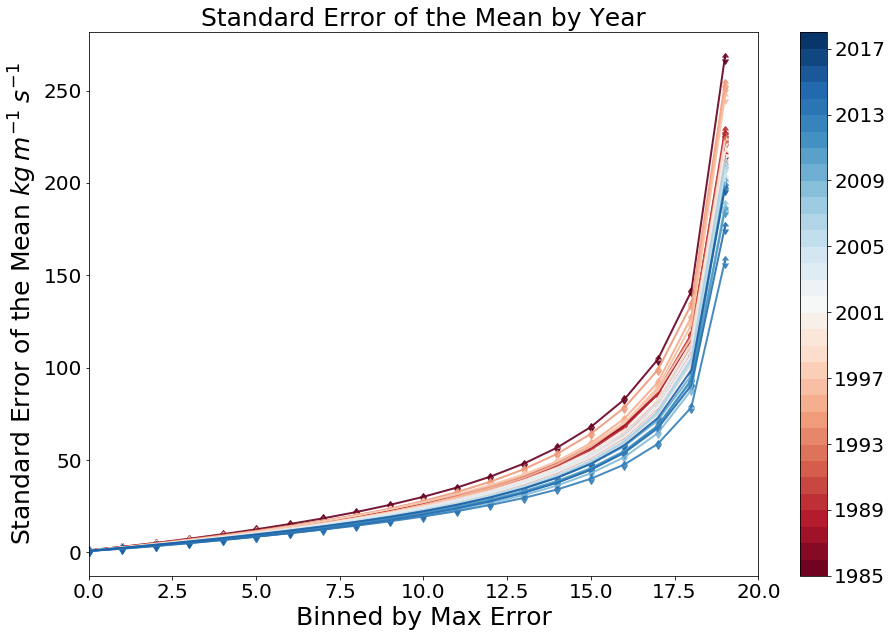

In [37]:
plt.figure(figsize=[15,10])  # inches

mymap = cm.RdBu
min, max = (1985, 2018)
step = 1
# to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

evenly_spaced_interval = np.linspace(0, 1, len(All_file_names)-1)
colors = [cm.RdBu(x) for x in evenly_spaced_interval]

# Plotting what I actually want
Z=np.arange(1987,2017,1).tolist()
count=0
for ad,bd,cd in zip(msebin_mA,msebin_sA,Z):
    # setting rgb color based on z normalized to my range
    plt.errorbar(np.arange(0,20),ad,yerr=bd, uplims=True, lolims=True,linewidth=2,color=colors[count],alpha=0.9)
#     plt.plot([0,140],[0,140],'k--')
    count+=1

    
plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
plt.xlabel('Binned by Max Error',fontsize=25)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Standard Error of the Mean by Year',fontsize=25)
cb = plt.colorbar(CS3) # using the colorbar info I got from contourf
cb.ax.tick_params(labelsize=20) 
plt.xlim([0,20])
plt.show()

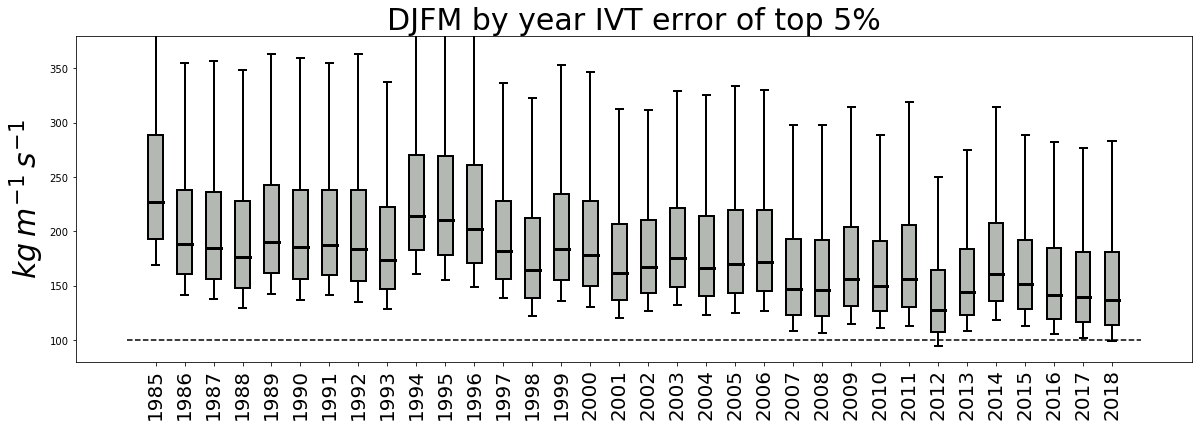

In [51]:
data_to_plot=[mlAe['1985'],mlAe['1986'],mlAe['1987'],mlAe['1988'],mlAe['1989'],mlAe['1990'],
              mlAe['1991'],mlAe['1992'],mlAe['1993'],mlAe['1994'],
             mlAe['1995'],mlAe['1996'],mlAe['1997'],mlAe['1998'],
             mlAe['1999'],mlAe['2000'],mlAe['2001'],mlAe['2002'],
             mlAe['2003'],mlAe['2004'],mlAe['2005'],mlAe['2006'],
             mlAe['2007'],mlAe['2008'],mlAe['2009'],mlAe['2010'],
             mlAe['2011'],mlAe['2012'],mlAe['2013'],mlAe['2014'],
             mlAe['2015'],mlAe['2016'],mlAe['2017'],mlAe['2018']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([80,380])
ax.set_xticklabels(mlAg.keys(),fontsize=20, rotation='vertical')
# ax.set_yticklabels(np.arange(0,1000,0.5),fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM by year IVT error of top 5%',fontsize=30)
plt.ylabel('$kg \:  m^{-1} \: s^{-1}$',fontsize=30)

plt.plot([0,35],[100,100],'k--')
# fname = '/Users/will/Desktop/Haupt/CRPS_MJO_Center.png'
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()

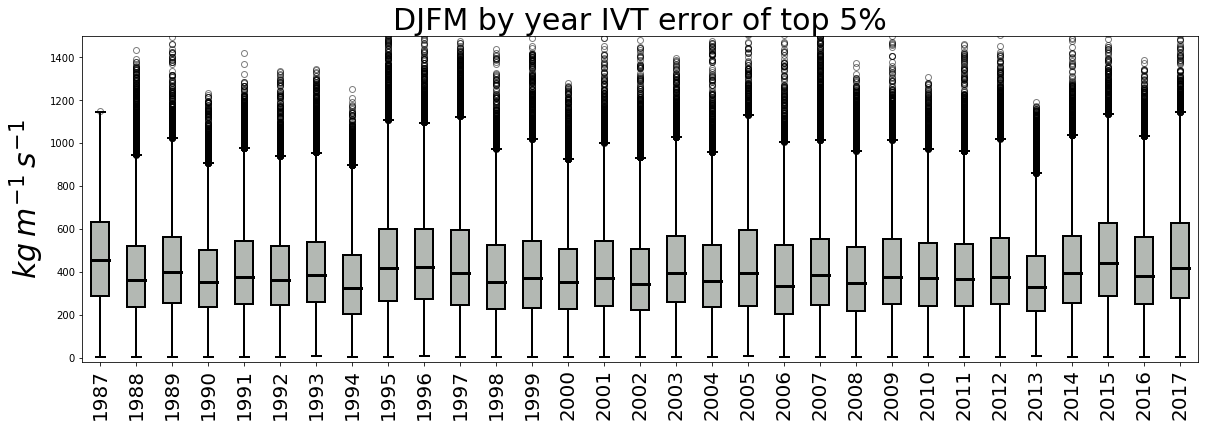

In [39]:
data_to_plot=[mlAt['1987'],mlAt['1988'],mlAt['1989'],mlAt['1990'],
              mlAt['1991'],mlAt['1992'],mlAt['1993'],mlAt['1994'],
             mlAt['1995'],mlAt['1996'],mlAt['1997'],mlAt['1998'],
             mlAt['1999'],mlAt['2000'],mlAt['2001'],mlAt['2002'],
             mlAt['2003'],mlAt['2004'],mlAt['2005'],mlAt['2006'],
             mlAt['2007'],mlAt['2008'],mlAt['2009'],mlAt['2010'],
             mlAt['2011'],mlAt['2012'],mlAt['2013'],mlAt['2014'],
             mlAt['2015'],mlAt['2016'],mlAt['2017']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([-20,1500])
ax.set_xticklabels(mlAt.keys(),fontsize=20, rotation='vertical')
# ax.set_yticklabels(np.arange(0,1000,0.5),fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM by year IVT error of top 5%',fontsize=30)
plt.ylabel('$kg \:  m^{-1} \: s^{-1}$',fontsize=30)

# fname = '/Users/will/Desktop/Haupt/CRPS_MJO_Center.png'
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()

1
/glade/scratch/wchapman/Reforecast/F000
Training on
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1985_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1986_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1987_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1988_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1989_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1990_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1991_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1992_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1993_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1994_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1995_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1996_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1997_500mb.nc
/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1998_500

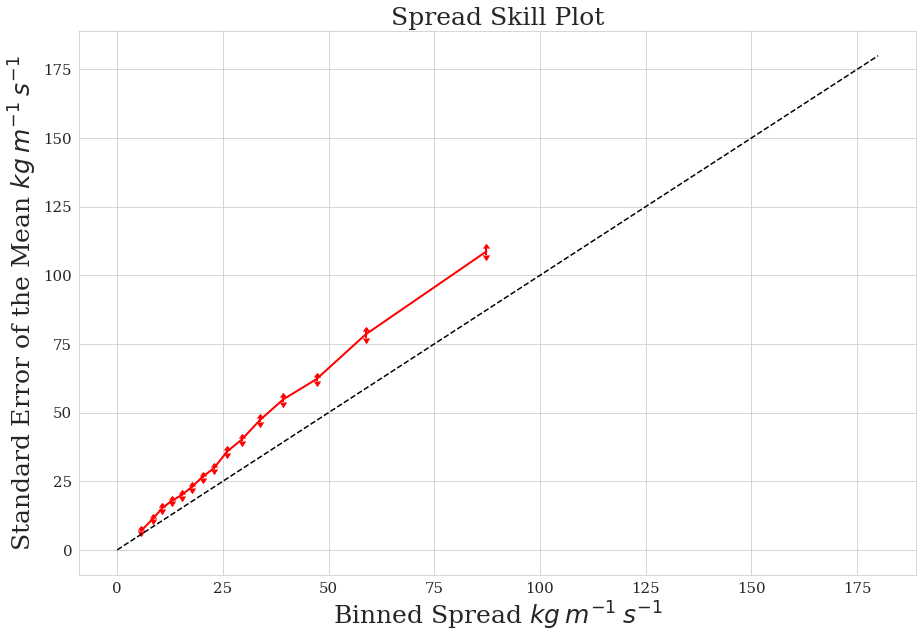

47.08298038924819
48.90957391366401
47.03440617724539
48.881388996400965
2.1381482381330272
1.6601898080332091
#################################################
testing: ['/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1987_500mb.nc']
validating: ['/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1986_500mb.nc']
#################################################
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1985_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1988_500mb.nc"...


/glade/work/wchapman/AnEn/CNN/Reforecast/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1989_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1990_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1991_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1992_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1993_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1994_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1995_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1996_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1997_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1998_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F000/train/F000_WY_1999_5

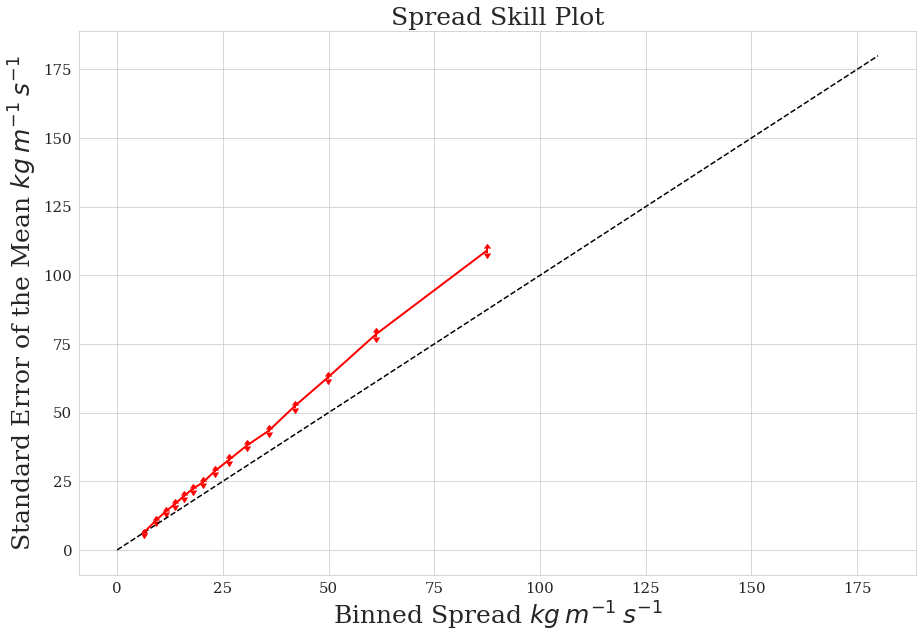

46.28300076371699
46.4674867027245
46.11252783481069
46.413275599078055
3.9687449373871857
2.243918142871479
banana
...binned spread skill...
saving: /glade/scratch/wchapman/Reforecast/models/NN_CRPS/F000/Spread_Skill_CRPS.npz


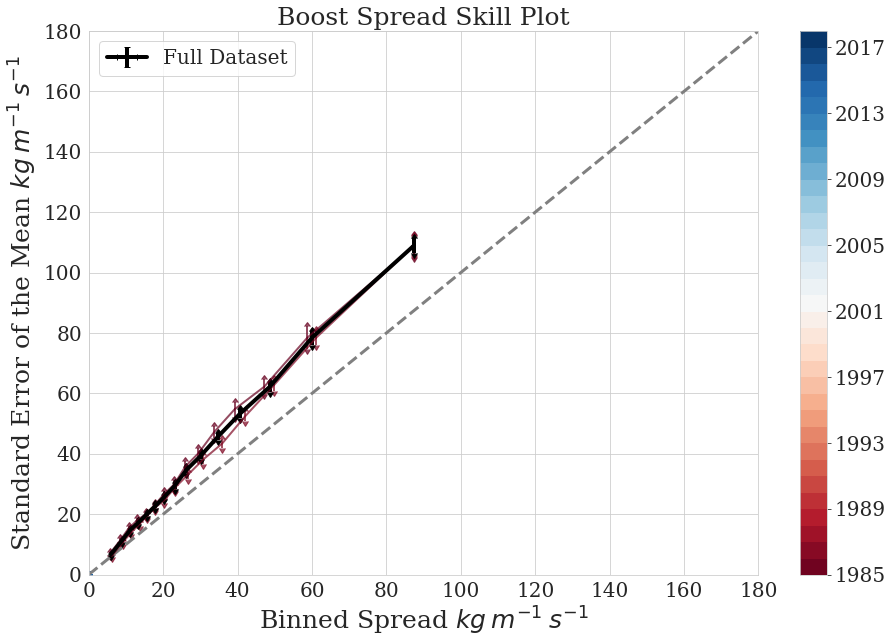

#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
#####################################################################
####################

/glade/work/wchapman/AnEn/CNN/Reforecast/utilsProb.py:216: RuntimeWarning: invalid value encountered in log
  post_matrix = numpy.log(post_matrix)


Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1987_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1988_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1989_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1990_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1991_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1992_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1993_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1994_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1995_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1996_500mb.nc"...
Reading data from: "/glade/scratch/wchapman/Reforecast/F006/train/F006_WY_1997_5

KeyboardInterrupt: 

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm

import os

import utilsProb
import utilsProbSS
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import properscoring as ps


os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


    
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


def rmse(guess,truth):
    n = len(truth)
    rms = np.linalg.norm(guess - truth) / np.sqrt(n)
    return rms


def bias(guess,truth):
    bb = np.mean(guess)-np.mean(truth)
    return bb

def corrss(guess,truth):
    bb = np.corrcoef(np.squeeze(guess),np.squeeze(truth))[0,1]
    return bb


def crmse(guess,truth):
    guess = np.squeeze(guess)
    truth = np.squeeze(truth)
    mg = np.mean(guess)
    mt = np.mean(truth)
    n = len(truth)
    bb=np.linalg.norm((guess-mg) - (truth-mt)) / np.sqrt(n)
    return bb

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def spreadskill(guess,truth,stddevver,numbins):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    distPP = np.ndarray.flatten(stddevver)
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    
    indexsort = np.argsort(distPP)
    err = (guess- truth)**2
    varianceall = distPP[indexsort]
    err_sort = err[indexsort]

    numbins = numbins 
    inds = np.zeros(len(varianceall))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(varianceall)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
    
    avgvar_m = []
    msebin_m = []

    avgvar_s = []
    msebin_s = []
    nummy =2000

    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tavg =0
        tmse =0
        tavg = np.zeros(nummy)
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tavg[ii]  = np.mean(np.random.choice(varianceall[locbin],len(locbin)))
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        avgvar_m = np.append(avgvar_m,np.mean(tavg))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        avgvar_s = np.append(avgvar_s,np.std(tavg))
        msebin_s = np.append(msebin_s,np.std(tmse))
    return avgvar_m,msebin_m,avgvar_s,msebin_s

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 8))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype,name='banjo'),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1),name='banjo2'),
  ])


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype,name='spoon'),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1),name='doon'),
  ])



def stnd_error_mean(guess,truth,numbins):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    

    err = (guess- truth)**2
    indexsort = np.argsort(err)
    err_sort = err[indexsort]
    
    truthSORT = truth[indexsort]
    guessSORT = guess[indexsort]

    numbins = numbins 
    inds = np.zeros(len(err_sort))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(err_sort)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
        
    msebin_m = []
    msebin_s = []
    nummy =2000
    maxlist=[]
    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tmse =0
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        msebin_s = np.append(msebin_s,np.std(tmse))
        
        if bb == np.max(np.unique(inds)):
            print('...getting max...')
            mlt = truthSORT[locbin]
            mlg = guessSORT[locbin]
            mle = np.sqrt((truthSORT[locbin]-guessSORT[locbin])**2)
            
        
    return msebin_m,msebin_s,mlt,mlg,mle



def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tfm.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)


def build_emb_model(n_features, n_outputs, hidden_nodes, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.01,
                    loss=crps_cost_function,
                    activation='relu', reg=None):
    """
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = tf.keras.layers.Input(shape=(n_features,))
    id_in = tf.keras.layers.Input(shape=(1,))
    emb = tf.keras.layers.Embedding(max_id + 1, emb_size)(id_in)
    emb = tf.keras.layers.Flatten()(emb)
    x = tf.keras.layers.Concatenate()([features_in, emb])
    for h in hidden_nodes:
        x = tf.keras.layers.Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = tf.keras.layers.Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = tf.keras.models.Model(inputs=[features_in, id_in], outputs=x)

    if compile:
        opt = tf.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss=loss)
    return model

def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution."""
    m = np.exp(mu + sigma**2 / 2.0)
    v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return m, v



for stepnum in range(1,10):
    tf.keras.backend.clear_session()
    print(stepnum)
    dd = '/glade/scratch/wchapman/Reforecast/'
    os.chdir(dd)
    yago= next(os.walk('.'))[1]
    yago = sorted(yago)
    subs = 'F'
    res = [ii for ii in yago if subs in ii] 
    res

    for fcast in res[:stepnum]: 
        os.chdir(dd+'/'+fcast)
        print(os.getcwd())
        #find all files in directory                                                                                                                                                  
        print('Training on')
        path = os.getcwd()
    train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb.nc", recursive=True)])
    for f in train_file_names:
        print(f)

    print('Validating on')
    validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb.nc", recursive=True)])
    for f in validate_file_names:
        print(f)
    
    print('Testing on')
    test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb.nc", recursive=True)])
    for f in test_file_names:
         print(f)
    
    All_file_names =train_file_names + validate_file_names +test_file_names 
    
    rang = 861 #number of lat/lon points
    latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/PNWpoints/'
    [latsDO,lonsDO,latind, lonind] = utilsProbSS.get_latlon_ind(latlonfolder)
    latsDO.shape
    latind = np.array(latind[:rang])
    lonind = np.array(lonind[:rang])
    latsDO = np.array(latsDO[:rang])
    lonsDO = np.array(lonsDO[:rang])

    norm_dict = utilsProbSS.get_image_normalization_params(train_file_names,latind,lonind)
    sys.stdout.flush()
    norm_dict_targ = utilsProbSS.get_image_normalization_params_targ(train_file_names,latind,lonind)
    # sys.stdout.flush()
    num_samps_train = utilsProb.count_samps(train_file_names)
    num_samps_val = utilsProb.count_samps(validate_file_names)
    num_samps_test = utilsProb.count_samps(test_file_names)

    print('number of training samples:',num_samps_train)
    # sys.stdout.flush()

    print('number of validation samples:',num_samps_val)
    # sys.stdout.flush()
    print('number of validation samples:',num_samps_test)
    num_samps_tot = num_samps_train+num_samps_val+num_samps_test
        
    ense = 60
    numbins = 15
    
    
    
    allinds = np.arange(len(All_file_names))
    avgvar_mA = np.zeros([len(All_file_names)-1,numbins])
    msebin_mA = np.zeros([len(All_file_names)-1,numbins])
    avgvar_sA = np.zeros([len(All_file_names)-1,numbins])
    msebin_sA = np.zeros([len(All_file_names)-1,numbins])

    mAl =np.array([])
    sAl =np.array([])
    yAl =np.array([])
    sssAl =np.empty([1,60])
    
    for ddfa, bb in enumerate(range(0,len(All_file_names)-1)):
        allinds = np.arange(len(All_file_names))
        test_fil_name = [All_file_names[allinds[bb+1]]]
        val_fil_name = [All_file_names[allinds[bb]]]

        rest = np.delete(allinds,[bb,bb+1])
        train_fil_name = np.array(All_file_names)[rest].tolist()
    
        print('#################################################')
        print('testing:',test_fil_name)
        print('validating:',val_fil_name)
        print('#################################################')
    
        num_samps_train = utilsProb.count_samps(train_fil_name)
        num_samps_val = utilsProb.count_samps(val_fil_name)

        print('...gathering data...')
        aa = utilsProbSS.deep_learning_generator_ss_mv(train_fil_name, num_samps_train*len(latind),norm_dict,norm_dict_targ,targ_LATinds=latind,targ_LONinds=lonind)
        adf = next(aa)
        x = adf[0]
        y = adf[1]
    
        ######## load testing ##############################################
        xpred = utilsProbSS.read_image_file(test_fil_name[0],latind,lonind)
        x_tst = np.reshape(xpred['predictor_matrix'],[xpred['predictor_matrix'].shape[0]*xpred['predictor_matrix'].shape[1],xpred['predictor_matrix'].shape[2]])
        y_tst = np.reshape(xpred['target_matrix'],[xpred['target_matrix'].shape[0]*xpred['target_matrix'].shape[1]])
        x_tst = utilsProbSS.normalize_images(x_tst,xpred['predictor_names'],norm_dict)[0]
        y_tst = utilsProbSS.normalize_images_targ(y_tst,xpred['target_name'],norm_dict_targ)[0]
        y_tst = np.expand_dims(y_tst,axis=1)

            ######## load testing ##############################################
            
            
        #remove x and y where x ==0 
        rmind = np.where(utilsProbSS.denormalize_images_targ(x[:,0],'IVT',norm_dict)==0)
        print('before shape:',y.shape)
        print('deleting:',rmind[0].shape,'indices')
        x = np.delete(x,rmind[0],0)
        y = np.delete(y,rmind[0],0)
        print('after shape:',y.shape)
    
        rmind = np.where(utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)==0)
        print('before shape test:',y_tst.shape)
        print('deleting test:',rmind[0].shape,'indices')
        x_tst = np.delete(x_tst,rmind[0],0)
        y_tst = np.delete(y_tst,rmind[0],0)
        print('after shape tst:',y_tst.shape)

        print('...Encoding Stations...')

        SUMID = np.unique(x[:,6]+x[:,7])
        #station ID integers 
        stID = np.zeros([x.shape[0],1])
        for jj,un in enumerate(SUMID):
            mats = np.where(x[:,6]+x[:,7]==un)
            stID[mats,:] = int(jj)
        stID=stID.astype(int)

        #station ID integers 
        stID_tst = np.zeros([x_tst.shape[0],1])
        for jj,un in enumerate(SUMID):
            mats = np.where(np.around(10000*np.round((x_tst[:,6]+x_tst[:,7]),4)).astype(int)==np.around(10000*np.round(un,4)).astype(int))[0]
            stID_tst[mats,:] = int(jj)
        stID_tst=stID_tst.astype(int)
        print('...done...')
        x=x[:,:6]
        x_tst=x_tst[:,:6]
    
        ### Model Build #### 
    
        in_shape = x.shape[1]
        print('In shape: ',in_shape)
        out_shape = 1
        print('Out shape: ',out_shape)
    
        max_id = np.max(stID)
        model = build_emb_model(in_shape,2,[30,40],2,max_id,compile=True)
        model.summary()
        valyr= val_fil_name[0].split('_500mb')[0]
        valyr =valyr.split('_')[2]
    
        tstyr= test_fil_name[0].split('_500mb')[0]
        tstyr =tstyr.split('_')[2]
    
        newdir = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/' +fcast+'/year_'+tstyr
    
        Wsave_name = newdir+'/cpf_CRPS_val_'+ valyr+'_test_'+tstyr+'.ckpt'
    
        print("... loading....",Wsave_name)
    
        ### CHANGE THIS FOR PRODUCTION RUNS ###########
        model.load_weights(Wsave_name)
        ### CHANGE THIS FOR PRODUCTION RUNS ###########
    
        #make model prediction
        yhat = model([x_tst,stID_tst])    
        m = yhat[:,0]
        m = (utilsProbSS.denormalize_images_targ(m,'IVT',norm_dict))
        s = np.abs(yhat[:,1]*norm_dict['IVT'][1])   
        WWRF = utilsProbSS.denormalize_images_targ(x_tst[:,0],'IVT',norm_dict)
        y_tst = (utilsProbSS.denormalize_images_targ(y_tst,'IVTm',norm_dict_targ))
    
        #form ensembles 
        m_All = np.zeros(len(m))
        sss_All = np.zeros([len(m),ense])
        s_All = np.zeros(len(m))
        for ii in range(len(m)):
            sss = np.random.normal(m[ii],s[ii],ense)
            sln=np.std(sss)
            mln=np.mean(sss)
            [mln,sln]=lognstat(np.mean(sss),np.std(sss))
            s_All[ii]=np.sqrt(sln)
            m_All[ii]=mln
            sss_All[ii,:] =np.exp(sss) 
    
    
        m = m_All
        m[np.isnan(m)]=0
        s=s_All
        s[np.isnan(m)]=0
    
        y_tst = np.exp(y_tst)
        WWRF = np.exp(WWRF)
        y_tst = y_tst[s<400]
        WWRF = WWRF[s<400]
        m = m[s<400]
        sss_All=sss_All[s<400,:]
        s = s[s<400]
        distPP = s
    
        mAl = np.append(mAl,np.ndarray.flatten(m))
        yAl = np.append(yAl,np.ndarray.flatten(y_tst))
        sAl = np.append(sAl,np.ndarray.flatten(s))
    
    
        if ddfa == 0:
            sssAl = sss_All
        else: 
            sssAl = np.concatenate([sssAl,sss_All],axis=0)
        
        print('...binned spread skill...')
        [avgvar_m,msebin_m,avgvar_s,msebin_s]=spreadskill(m,y_tst,distPP,numbins)
    
        avgvar_mA[bb,:] = np.squeeze(avgvar_m)
        msebin_mA[bb,:] = np.squeeze(msebin_m)
        avgvar_sA[bb,:] = np.squeeze(avgvar_s)
        msebin_sA[bb,:] = np.squeeze(msebin_s)
    
        plt.figure(figsize=[15,10])  # inches
        plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color='r',linewidth=2)
        plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
        plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

        plt.tick_params(axis='x', labelsize=15)
        plt.tick_params(axis='y', labelsize=15)
        plt.title('Spread Skill Plot',fontsize=25)

        plt.plot([0,180],[0,180],'k--')
        plt.show()
    
        print(rmse(np.expand_dims(m,axis=1),y_tst))
        print(rmse(np.expand_dims(WWRF,axis=1),y_tst))
        print(crmse(np.expand_dims(m,axis=1),y_tst))
        print(crmse(np.expand_dims(WWRF,axis=1),y_tst))
        print(bias(np.expand_dims(m,axis=1),y_tst))
        print(bias(np.expand_dims(WWRF,axis=1),y_tst))
        if ddfa ==1:
            break
    
    print('banana')
    distPPT = (np.squeeze(sAl))
    print('...binned spread skill...')
    [avgvar_mT,msebin_mT,avgvar_sT,msebin_sT]=spreadskill(mAl,yAl,distPPT,numbins)
    
    print('saving:','/glade/scratch/wchapman/Reforecast/models/NN_CRPS/'+fcast+'/Spread_Skill_CRPS.npz')
    np.savez_compressed('/glade/scratch/wchapman/Reforecast/models/NN_CRPS/'+fcast+'/Spread_Skill_CRPS.npz',mAl=mAl,yAl=yAl,distPPT=distPPT,
                    numbins=numbins,avgvar_mA=avgvar_mA,msebin_mA=msebin_mA,avgvar_sA=avgvar_sA,msebin_sA=msebin_sA)

    crps_ense = ps.crps_ensemble(np.squeeze(yAl[yAl>250]),sssAl[np.squeeze([yAl>250][0][:]),:])
    np.savez_compressed('/glade/scratch/wchapman/Reforecast/models/NN_CRPS/'+fcast+'/twCRPS_CRPS.npz',yAl=yAl,sssAl=sssAl,crps_ense=crps_ense)
    
    
    
    plt.figure(figsize=[15,10])  # inches
    mymap = cm.RdBu
    min, max = (1985, 2018)
    step = 1
    # to provide my colorbar info, then clearing the figure
    Z = [[0,0],[0,0]]
    levels = range(min,max+step,step)
    CS3 = plt.contourf(Z, levels, cmap=mymap)
    plt.clf()


    evenly_spaced_interval = np.linspace(0, 1, len(All_file_names)-1)
    colors = [cm.RdBu(x) for x in evenly_spaced_interval]

    # Plotting what I actually want
    Z=np.arange(1987,2017,1).tolist()
    count=0
    for ad,bd,cd,dd,ed in zip(avgvar_mA,msebin_mA,avgvar_sA,msebin_sA,Z):
            # setting rgb color based on z normalized to my range
        plt.errorbar(ad, bd, xerr=3*cd, yerr=3*dd, uplims=True, lolims=True,linewidth=2,color=colors[count],alpha=0.7)
    
        count+=1
    
    plt.errorbar(avgvar_mT, msebin_mT, xerr=3*avgvar_sT, yerr=3*msebin_sT, uplims=True, lolims=True,linewidth=4,color='k',alpha=1,label='Full Dataset')
    plt.legend(fontsize=20)
    plt.plot([0,200],[0,200],linestyle='--',linewidth=3,color=[0.5,0.5,0.5])

    plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=25)
    plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=25)

    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.title('Boost Spread Skill Plot',fontsize=25)
    cb = plt.colorbar(CS3) # using the colorbar info I got from contourf
    cb.ax.tick_params(labelsize=20) 
    plt.xlim([0,180])
    plt.ylim([0,180])
    fname = '/glade/scratch/wchapman/Reforecast/models/NN_CRPS/'+fcast+'/Spread_Skill_CRPS.png'
    plt.savefig(fname, dpi=200, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=False, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')
    print('#####################################################################')